TP1 - Recalage d'images
=============

In [1]:
import numpy as np
import numpy.linalg as npl
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [10]:
def interpol(f,ux,uy) :
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),f)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

def dx(im) :
    d=np.zeros(im.shape)
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d #retourne dx*im
def dy(im) :
    d=np.zeros(im.shape)
    d[:,:-1]=im[:,1:]-im[:,:-1]
    return d
def dxT(im) :
    d=np.zeros(im.shape)
    d[0,:] = -im[0,:]
    d[1:-1,:] = im[:-2,:] - im[1:-1:,:]
    d[-1,:] = im[-2,:]
    return d  
def dyT(im) :
    d=np.zeros(im.shape)
    d[:,0] = -im[:,0]
    d[:,1:-1] = im[:,:-2] - im[:,1:-1]
    d[:,-1] = im[:,-2]    
    return d

def objective_function(f,g,ux,uy,lamb,mu) :
    fu=interpol(f,ux,uy)
    R = mu/2*npl.norm(dx(uy)+dy(ux))**2 + ((lamb+mu)/2)*npl.norm(dx(ux) + dy(uy))**2
    E = 1/2*npl.norm(fu  - g)**2
    obj = E + R
    return obj,fu

def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step

def RecalageDG(f,g,lamb,mu,nitermax,stepini) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)   

        gradEx = (fu - g)*interpol(dx(f),ux,uy)
        gradEy = (fu - g)*interpol(dy(f),ux,uy)
        gradE = np.array([gradEx, gradEy])
        
        
        # Gradient of R at point u
        gradRx = mu*(dyT(dy(ux)) + dyT(dx(uy))) + (lamb+mu)*(dxT(dx(ux)) + (dxT(dy(uy))))
        gradRy = mu * (dxT(dy(ux)) + dxT(dx(uy))) + (lamb + mu)*(dyT(dx(ux)) + dyT(dy(uy)))
        
        
        # Gradient of E+R at point u
        gradx = gradEx + gradRx
        grady = gradEy + gradRy
        
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

#df déjà interpolé
def JPsi(vx,vy,df,lamb,mu) :
    JPsi0 = df[0]*vx+df[1]*vy
    JPsi1 = np.sqrt(mu)*dy(vx)+np.sqrt(mu)*dx(vy)
    JPsi2 = np.sqrt(mu+lamb)*dx(vx)+ np.sqrt(mu+lamb)*dy(vy)
    
    return [JPsi0,JPsi1,JPsi2]

def JTPsi(phi,df,lamb,mu) :
    ux =df[0]*phi[0]+ np.sqrt(mu)*dyT(phi[1])+ np.sqrt(mu+lamb)*dxT(phi[2])
    uy =df[1]*phi[0]+ np.sqrt(mu)*dxT(phi[1])+ np.sqrt(mu+lamb)*dyT(phi[2])

    return [ux,uy]

def JTJ(vx,vy,df,lamb,mu,epsilon) :
    J = JPsi(vx,vy,df,lamb,mu)
    JJ = JTPsi(J,df,lamb,mu)
    #JJ += epsilon*vx + epsilon*vy
    uxs = JJ[0]+epsilon*vx
    uys = JJ[1]+epsilon*vy
    
    return uxs,uys

def CGSolve(u0x,u0y,lamb,mu,b,epsilon,df) :
    nitmax=100;
    ux=u0x; uy=u0y; #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,df,lamb,mu,epsilon);
    rx=b[0]-Ax
    ry=b[1]-Ay
    px=rx
    py=ry
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,df,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return [ux,uy]

def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)
    
   
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dfx=dx(f)
    dfy=dy(f)
    df = [dfx,dfy]
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        dfu=[interpol(dfx,ux,uy),interpol(dfy,ux,uy)] ##on dérive puis on interpole
        phi = [fu - g,np.sqrt(mu)*(dx(uy) + dy(ux)), np.sqrt(mu + lamb)*(dx(ux) + dy(uy))]
        b = JTPsi(phi,dfu,lamb,mu)
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfu)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

def gaussianFilter(img,factor):
    kernel = np.ones((factor,factor),np.float32)/(factor**2)
    return cv2.filter2D(img,-1,kernel)

In [7]:
def get_images():
    band1 = np.loadtxt("band1.txt")
    band2 = np.loadtxt("band2.txt")
    return band1, band2
b1,b2 = get_images()

<ipython-input-16-499e374b134e>:7: RuntimeWarning: divide by zero encountered in log
  im2 = ax[1].imshow(10*np.log(b2),vmin=-40,vmax=0)


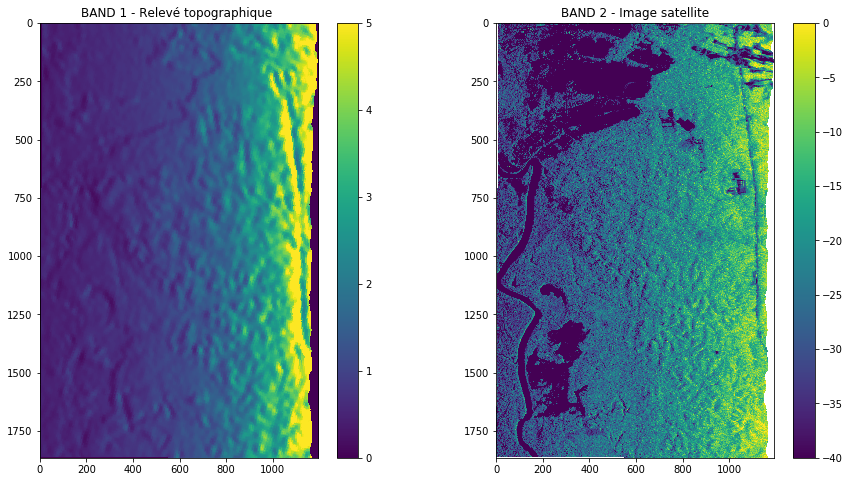

In [16]:
fig,ax = plt.subplots(1,2, figsize=(15,8))

im1 = ax[0].imshow(b1, vmin = 0, vmax = 5)
ax[0].set_title("BAND 1 - Relevé topographique ")
fig.colorbar(im1,ax=ax[0])

im2 = ax[1].imshow(10*np.log(b2),vmin=-40,vmax=0)
ax[1].set_title("BAND 2 - Image satellite")
fig.colorbar(im2,ax=ax[1])

plt.show()

In [30]:
res = []

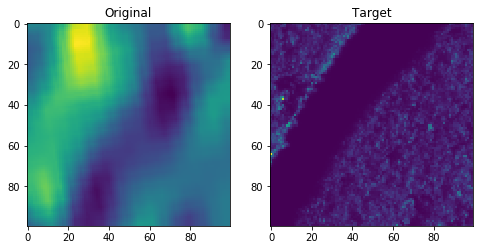

In [32]:
target = b2[1000:1100,10:110]
original = gaussianFilter(b1[1000:1100,10:110],5)
#template = np.roll(target,5,axis=0)


fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(target)
ax[1].set_title("Target")
# ax[1].imshow(template)
# ax[1].set_title("Template (5px shift)")
plt.show()


## Test optim des param

In [33]:
lamb = np.linspace(-1,1.5,10)
mu = np.copy(0.1*lamb)
nitertab = np.zeros(10)
nitermax=3000
step0 = 0.01
for i in range(10):
    ux,uy,CF,step,nitertab[i]=RecalageDG(original,target,lamb[i],mu[i],nitermax,step0)

iteration : 3  cost function : 989.2402160592155 step : 0.08
iteration : 6  cost function : 989.0395097024735 step : 0.64
iteration : 9  cost function : -11340.615879281964 step : 5.12
iteration : 12  cost function : -4787323717996126.0 step : 40.96
iteration : 15  cost function : -8.281817651281918e+32 step : 327.68
iteration : 18  cost function : -4.1972459117607247e+55 step : 2621.44
iteration : 21  cost function : -5.870966506390255e+83 step : 20971.52
iteration : 24  cost function : -2.2140542462841035e+117 step : 167772.16
iteration : 27  cost function : -2.22648935427806e+156 step : 1342177.28
iteration : 30  cost function : -5.936562391299995e+200 step : 10737418.24
iteration : 33  cost function : -4.183480652744049e+250 step : 85899345.92
iteration : 36  cost function : -7.776437632065155e+305 step : 687194767.36
iteration : 39  cost function : -inf step : 5497558138.88
iteration : 42  cost function : -inf step : 43980465111.04
iteration : 45  cost function : -inf step : 35184

<ipython-input-10-a3ea44a1b84c>:40: RuntimeWarning: overflow encountered in multiply
  tmpx=ux-step*descentx
<ipython-input-10-a3ea44a1b84c>:41: RuntimeWarning: overflow encountered in multiply
  tmpy=uy-step*descenty
<ipython-input-10-a3ea44a1b84c>:12: RuntimeWarning: invalid value encountered in subtract
  d[:-1,:]=im[1:,:]-im[:-1,:]
<ipython-input-10-a3ea44a1b84c>:16: RuntimeWarning: invalid value encountered in subtract
  d[:,:-1]=im[:,1:]-im[:,:-1]
<ipython-input-10-a3ea44a1b84c>:33: RuntimeWarning: invalid value encountered in add
  R = mu/2*npl.norm(dx(uy)+dy(ux))**2 + ((lamb+mu)/2)*npl.norm(dx(ux) + dy(uy))**2
<ipython-input-10-a3ea44a1b84c>:27: RuntimeWarning: invalid value encountered in subtract
  d[:,1:-1] = im[:,:-2] - im[:,1:-1]
<ipython-input-10-a3ea44a1b84c>:68: RuntimeWarning: invalid value encountered in add
  gradRx = mu*(dyT(dy(ux)) + dyT(dx(uy))) + (lamb+mu)*(dxT(dx(ux)) + (dxT(dy(uy))))
<ipython-input-10-a3ea44a1b84c>:21: RuntimeWarning: invalid value encountered 

iteration : 57  cost function : nan step : 1441151880758558.8
iteration : 60  cost function : nan step : 1.152921504606847e+16
iteration : 63  cost function : nan step : 9.223372036854776e+16
iteration : 66  cost function : nan step : 7.378697629483821e+17
iteration : 69  cost function : nan step : 5.902958103587057e+18
iteration : 72  cost function : nan step : 4.722366482869645e+19
iteration : 75  cost function : nan step : 3.777893186295716e+20
iteration : 78  cost function : nan step : 3.022314549036573e+21
iteration : 81  cost function : nan step : 2.4178516392292584e+22
iteration : 84  cost function : nan step : 1.9342813113834067e+23
iteration : 87  cost function : nan step : 1.5474250491067254e+24
iteration : 90  cost function : nan step : 1.2379400392853803e+25
iteration : 93  cost function : nan step : 9.903520314283042e+25
iteration : 96  cost function : nan step : 7.922816251426434e+26
iteration : 99  cost function : nan step : 6.338253001141147e+27
iteration : 102  cost fu

iteration : 441  cost function : nan step : 5.678427533559429e+130
iteration : 444  cost function : nan step : 4.542742026847543e+131
iteration : 447  cost function : nan step : 3.6341936214780345e+132
iteration : 450  cost function : nan step : 2.9073548971824276e+133
iteration : 453  cost function : nan step : 2.325883917745942e+134
iteration : 456  cost function : nan step : 1.8607071341967537e+135
iteration : 459  cost function : nan step : 1.488565707357403e+136
iteration : 462  cost function : nan step : 1.1908525658859224e+137
iteration : 465  cost function : nan step : 9.526820527087379e+137
iteration : 468  cost function : nan step : 7.621456421669903e+138
iteration : 471  cost function : nan step : 6.097165137335922e+139
iteration : 474  cost function : nan step : 4.877732109868738e+140
iteration : 477  cost function : nan step : 3.9021856878949904e+141
iteration : 480  cost function : nan step : 3.1217485503159923e+142
iteration : 483  cost function : nan step : 2.4973988402

iteration : 816  cost function : nan step : 4.3699499387321414e+243
iteration : 819  cost function : nan step : 3.495959950985713e+244
iteration : 822  cost function : nan step : 2.7967679607885705e+245
iteration : 825  cost function : nan step : 2.2374143686308564e+246
iteration : 828  cost function : nan step : 1.789931494904685e+247
iteration : 831  cost function : nan step : 1.431945195923748e+248
iteration : 834  cost function : nan step : 1.1455561567389985e+249
iteration : 837  cost function : nan step : 9.164449253911988e+249
iteration : 840  cost function : nan step : 7.33155940312959e+250
iteration : 843  cost function : nan step : 5.865247522503672e+251
iteration : 846  cost function : nan step : 4.692198018002938e+252
iteration : 849  cost function : nan step : 3.75375841440235e+253
iteration : 852  cost function : nan step : 3.00300673152188e+254
iteration : 855  cost function : nan step : 2.402405385217504e+255
iteration : 858  cost function : nan step : 1.921924308174003

iteration : 1251  cost function : nan step : inf
iteration : 1254  cost function : nan step : inf
iteration : 1257  cost function : nan step : inf
iteration : 1260  cost function : nan step : inf
iteration : 1263  cost function : nan step : inf
iteration : 1266  cost function : nan step : inf
iteration : 1269  cost function : nan step : inf
iteration : 1272  cost function : nan step : inf
iteration : 1275  cost function : nan step : inf
iteration : 1278  cost function : nan step : inf
iteration : 1281  cost function : nan step : inf
iteration : 1284  cost function : nan step : inf
iteration : 1287  cost function : nan step : inf
iteration : 1290  cost function : nan step : inf
iteration : 1293  cost function : nan step : inf
iteration : 1296  cost function : nan step : inf
iteration : 1299  cost function : nan step : inf
iteration : 1302  cost function : nan step : inf
iteration : 1305  cost function : nan step : inf
iteration : 1308  cost function : nan step : inf
iteration : 1311  co

iteration : 1755  cost function : nan step : inf
iteration : 1758  cost function : nan step : inf
iteration : 1761  cost function : nan step : inf
iteration : 1764  cost function : nan step : inf
iteration : 1767  cost function : nan step : inf
iteration : 1770  cost function : nan step : inf
iteration : 1773  cost function : nan step : inf
iteration : 1776  cost function : nan step : inf
iteration : 1779  cost function : nan step : inf
iteration : 1782  cost function : nan step : inf
iteration : 1785  cost function : nan step : inf
iteration : 1788  cost function : nan step : inf
iteration : 1791  cost function : nan step : inf
iteration : 1794  cost function : nan step : inf
iteration : 1797  cost function : nan step : inf
iteration : 1800  cost function : nan step : inf
iteration : 1803  cost function : nan step : inf
iteration : 1806  cost function : nan step : inf
iteration : 1809  cost function : nan step : inf
iteration : 1812  cost function : nan step : inf
iteration : 1815  co

iteration : 2259  cost function : nan step : inf
iteration : 2262  cost function : nan step : inf
iteration : 2265  cost function : nan step : inf
iteration : 2268  cost function : nan step : inf
iteration : 2271  cost function : nan step : inf
iteration : 2274  cost function : nan step : inf
iteration : 2277  cost function : nan step : inf
iteration : 2280  cost function : nan step : inf
iteration : 2283  cost function : nan step : inf
iteration : 2286  cost function : nan step : inf
iteration : 2289  cost function : nan step : inf
iteration : 2292  cost function : nan step : inf
iteration : 2295  cost function : nan step : inf
iteration : 2298  cost function : nan step : inf
iteration : 2301  cost function : nan step : inf
iteration : 2304  cost function : nan step : inf
iteration : 2307  cost function : nan step : inf
iteration : 2310  cost function : nan step : inf
iteration : 2313  cost function : nan step : inf
iteration : 2316  cost function : nan step : inf
iteration : 2319  co

iteration : 2775  cost function : nan step : inf
iteration : 2778  cost function : nan step : inf
iteration : 2781  cost function : nan step : inf
iteration : 2784  cost function : nan step : inf
iteration : 2787  cost function : nan step : inf
iteration : 2790  cost function : nan step : inf
iteration : 2793  cost function : nan step : inf
iteration : 2796  cost function : nan step : inf
iteration : 2799  cost function : nan step : inf
iteration : 2802  cost function : nan step : inf
iteration : 2805  cost function : nan step : inf
iteration : 2808  cost function : nan step : inf
iteration : 2811  cost function : nan step : inf
iteration : 2814  cost function : nan step : inf
iteration : 2817  cost function : nan step : inf
iteration : 2820  cost function : nan step : inf
iteration : 2823  cost function : nan step : inf
iteration : 2826  cost function : nan step : inf
iteration : 2829  cost function : nan step : inf
iteration : 2832  cost function : nan step : inf
iteration : 2835  co

<ipython-input-10-a3ea44a1b84c>:12: RuntimeWarning: overflow encountered in subtract
  d[:-1,:]=im[1:,:]-im[:-1,:]
<ipython-input-10-a3ea44a1b84c>:16: RuntimeWarning: overflow encountered in subtract
  d[:,:-1]=im[:,1:]-im[:,:-1]
<ipython-input-10-a3ea44a1b84c>:33: RuntimeWarning: overflow encountered in add
  R = mu/2*npl.norm(dx(uy)+dy(ux))**2 + ((lamb+mu)/2)*npl.norm(dx(ux) + dy(uy))**2
<ipython-input-10-a3ea44a1b84c>:27: RuntimeWarning: overflow encountered in subtract
  d[:,1:-1] = im[:,:-2] - im[:,1:-1]
<ipython-input-10-a3ea44a1b84c>:68: RuntimeWarning: overflow encountered in add
  gradRx = mu*(dyT(dy(ux)) + dyT(dx(uy))) + (lamb+mu)*(dxT(dx(ux)) + (dxT(dy(uy))))
<ipython-input-10-a3ea44a1b84c>:21: RuntimeWarning: overflow encountered in subtract
  d[1:-1,:] = im[:-2,:] - im[1:-1:,:]
<ipython-input-10-a3ea44a1b84c>:69: RuntimeWarning: overflow encountered in add
  gradRy = mu * (dxT(dy(ux)) + dxT(dx(uy))) + (lamb + mu)*(dyT(dx(ux)) + dyT(dy(uy)))


iteration : 66  cost function : nan step : 7.378697629483821e+17
iteration : 69  cost function : nan step : 5.902958103587057e+18
iteration : 72  cost function : nan step : 4.722366482869645e+19
iteration : 75  cost function : nan step : 3.777893186295716e+20
iteration : 78  cost function : nan step : 3.022314549036573e+21
iteration : 81  cost function : nan step : 2.4178516392292584e+22
iteration : 84  cost function : nan step : 1.9342813113834067e+23
iteration : 87  cost function : nan step : 1.5474250491067254e+24
iteration : 90  cost function : nan step : 1.2379400392853803e+25
iteration : 93  cost function : nan step : 9.903520314283042e+25
iteration : 96  cost function : nan step : 7.922816251426434e+26
iteration : 99  cost function : nan step : 6.338253001141147e+27
iteration : 102  cost function : nan step : 5.070602400912918e+28
iteration : 105  cost function : nan step : 4.056481920730334e+29
iteration : 108  cost function : nan step : 3.2451855365842673e+30
iteration : 111  

iteration : 438  cost function : nan step : 7.098034416949286e+129
iteration : 441  cost function : nan step : 5.678427533559429e+130
iteration : 444  cost function : nan step : 4.542742026847543e+131
iteration : 447  cost function : nan step : 3.6341936214780345e+132
iteration : 450  cost function : nan step : 2.9073548971824276e+133
iteration : 453  cost function : nan step : 2.325883917745942e+134
iteration : 456  cost function : nan step : 1.8607071341967537e+135
iteration : 459  cost function : nan step : 1.488565707357403e+136
iteration : 462  cost function : nan step : 1.1908525658859224e+137
iteration : 465  cost function : nan step : 9.526820527087379e+137
iteration : 468  cost function : nan step : 7.621456421669903e+138
iteration : 471  cost function : nan step : 6.097165137335922e+139
iteration : 474  cost function : nan step : 4.877732109868738e+140
iteration : 477  cost function : nan step : 3.9021856878949904e+141
iteration : 480  cost function : nan step : 3.12174855031

iteration : 813  cost function : nan step : 5.462437423415177e+242
iteration : 816  cost function : nan step : 4.3699499387321414e+243
iteration : 819  cost function : nan step : 3.495959950985713e+244
iteration : 822  cost function : nan step : 2.7967679607885705e+245
iteration : 825  cost function : nan step : 2.2374143686308564e+246
iteration : 828  cost function : nan step : 1.789931494904685e+247
iteration : 831  cost function : nan step : 1.431945195923748e+248
iteration : 834  cost function : nan step : 1.1455561567389985e+249
iteration : 837  cost function : nan step : 9.164449253911988e+249
iteration : 840  cost function : nan step : 7.33155940312959e+250
iteration : 843  cost function : nan step : 5.865247522503672e+251
iteration : 846  cost function : nan step : 4.692198018002938e+252
iteration : 849  cost function : nan step : 3.75375841440235e+253
iteration : 852  cost function : nan step : 3.00300673152188e+254
iteration : 855  cost function : nan step : 2.402405385217504

iteration : 1245  cost function : nan step : inf
iteration : 1248  cost function : nan step : inf
iteration : 1251  cost function : nan step : inf
iteration : 1254  cost function : nan step : inf
iteration : 1257  cost function : nan step : inf
iteration : 1260  cost function : nan step : inf
iteration : 1263  cost function : nan step : inf
iteration : 1266  cost function : nan step : inf
iteration : 1269  cost function : nan step : inf
iteration : 1272  cost function : nan step : inf
iteration : 1275  cost function : nan step : inf
iteration : 1278  cost function : nan step : inf
iteration : 1281  cost function : nan step : inf
iteration : 1284  cost function : nan step : inf
iteration : 1287  cost function : nan step : inf
iteration : 1290  cost function : nan step : inf
iteration : 1293  cost function : nan step : inf
iteration : 1296  cost function : nan step : inf
iteration : 1299  cost function : nan step : inf
iteration : 1302  cost function : nan step : inf
iteration : 1305  co

iteration : 1755  cost function : nan step : inf
iteration : 1758  cost function : nan step : inf
iteration : 1761  cost function : nan step : inf
iteration : 1764  cost function : nan step : inf
iteration : 1767  cost function : nan step : inf
iteration : 1770  cost function : nan step : inf
iteration : 1773  cost function : nan step : inf
iteration : 1776  cost function : nan step : inf
iteration : 1779  cost function : nan step : inf
iteration : 1782  cost function : nan step : inf
iteration : 1785  cost function : nan step : inf
iteration : 1788  cost function : nan step : inf
iteration : 1791  cost function : nan step : inf
iteration : 1794  cost function : nan step : inf
iteration : 1797  cost function : nan step : inf
iteration : 1800  cost function : nan step : inf
iteration : 1803  cost function : nan step : inf
iteration : 1806  cost function : nan step : inf
iteration : 1809  cost function : nan step : inf
iteration : 1812  cost function : nan step : inf
iteration : 1815  co

iteration : 2268  cost function : nan step : inf
iteration : 2271  cost function : nan step : inf
iteration : 2274  cost function : nan step : inf
iteration : 2277  cost function : nan step : inf
iteration : 2280  cost function : nan step : inf
iteration : 2283  cost function : nan step : inf
iteration : 2286  cost function : nan step : inf
iteration : 2289  cost function : nan step : inf
iteration : 2292  cost function : nan step : inf
iteration : 2295  cost function : nan step : inf
iteration : 2298  cost function : nan step : inf
iteration : 2301  cost function : nan step : inf
iteration : 2304  cost function : nan step : inf
iteration : 2307  cost function : nan step : inf
iteration : 2310  cost function : nan step : inf
iteration : 2313  cost function : nan step : inf
iteration : 2316  cost function : nan step : inf
iteration : 2319  cost function : nan step : inf
iteration : 2322  cost function : nan step : inf
iteration : 2325  cost function : nan step : inf
iteration : 2328  co

iteration : 2781  cost function : nan step : inf
iteration : 2784  cost function : nan step : inf
iteration : 2787  cost function : nan step : inf
iteration : 2790  cost function : nan step : inf
iteration : 2793  cost function : nan step : inf
iteration : 2796  cost function : nan step : inf
iteration : 2799  cost function : nan step : inf
iteration : 2802  cost function : nan step : inf
iteration : 2805  cost function : nan step : inf
iteration : 2808  cost function : nan step : inf
iteration : 2811  cost function : nan step : inf
iteration : 2814  cost function : nan step : inf
iteration : 2817  cost function : nan step : inf
iteration : 2820  cost function : nan step : inf
iteration : 2823  cost function : nan step : inf
iteration : 2826  cost function : nan step : inf
iteration : 2829  cost function : nan step : inf
iteration : 2832  cost function : nan step : inf
iteration : 2835  cost function : nan step : inf
iteration : 2838  cost function : nan step : inf
iteration : 2841  co

iteration : 216  cost function : nan step : 1.0531229166855719e+63
iteration : 219  cost function : nan step : 8.424983333484575e+63
iteration : 222  cost function : nan step : 6.73998666678766e+64
iteration : 225  cost function : nan step : 5.391989333430128e+65
iteration : 228  cost function : nan step : 4.3135914667441025e+66
iteration : 231  cost function : nan step : 3.450873173395282e+67
iteration : 234  cost function : nan step : 2.7606985387162256e+68
iteration : 237  cost function : nan step : 2.2085588309729805e+69
iteration : 240  cost function : nan step : 1.7668470647783844e+70
iteration : 243  cost function : nan step : 1.4134776518227075e+71
iteration : 246  cost function : nan step : 1.130782121458166e+72
iteration : 249  cost function : nan step : 9.046256971665328e+72
iteration : 252  cost function : nan step : 7.237005577332262e+73
iteration : 255  cost function : nan step : 5.78960446186581e+74
iteration : 258  cost function : nan step : 4.631683569492648e+75
iterat

iteration : 591  cost function : nan step : 8.10452259547069e+175
iteration : 594  cost function : nan step : 6.483618076376552e+176
iteration : 597  cost function : nan step : 5.186894461101241e+177
iteration : 600  cost function : nan step : 4.149515568880993e+178
iteration : 603  cost function : nan step : 3.3196124551047944e+179
iteration : 606  cost function : nan step : 2.6556899640838355e+180
iteration : 609  cost function : nan step : 2.1245519712670684e+181
iteration : 612  cost function : nan step : 1.6996415770136548e+182
iteration : 615  cost function : nan step : 1.3597132616109238e+183
iteration : 618  cost function : nan step : 1.087770609288739e+184
iteration : 621  cost function : nan step : 8.702164874309912e+184
iteration : 624  cost function : nan step : 6.96173189944793e+185
iteration : 627  cost function : nan step : 5.569385519558344e+186
iteration : 630  cost function : nan step : 4.455508415646675e+187
iteration : 633  cost function : nan step : 3.5644067325173

iteration : 972  cost function : nan step : 3.99168061906944e+290
iteration : 975  cost function : nan step : 3.193344495255552e+291
iteration : 978  cost function : nan step : 2.5546755962044414e+292
iteration : 981  cost function : nan step : 2.043740476963553e+293
iteration : 984  cost function : nan step : 1.6349923815708425e+294
iteration : 987  cost function : nan step : 1.307993905256674e+295
iteration : 990  cost function : nan step : 1.0463951242053392e+296
iteration : 993  cost function : nan step : 8.371160993642714e+296
iteration : 996  cost function : nan step : 6.696928794914171e+297
iteration : 999  cost function : nan step : 5.357543035931337e+298
iteration : 1002  cost function : nan step : 4.2860344287450694e+299
iteration : 1005  cost function : nan step : 3.4288275429960555e+300
iteration : 1008  cost function : nan step : 2.7430620343968444e+301
iteration : 1011  cost function : nan step : 2.1944496275174755e+302
iteration : 1014  cost function : nan step : 1.75555

iteration : 1467  cost function : nan step : inf
iteration : 1470  cost function : nan step : inf
iteration : 1473  cost function : nan step : inf
iteration : 1476  cost function : nan step : inf
iteration : 1479  cost function : nan step : inf
iteration : 1482  cost function : nan step : inf
iteration : 1485  cost function : nan step : inf
iteration : 1488  cost function : nan step : inf
iteration : 1491  cost function : nan step : inf
iteration : 1494  cost function : nan step : inf
iteration : 1497  cost function : nan step : inf
iteration : 1500  cost function : nan step : inf
iteration : 1503  cost function : nan step : inf
iteration : 1506  cost function : nan step : inf
iteration : 1509  cost function : nan step : inf
iteration : 1512  cost function : nan step : inf
iteration : 1515  cost function : nan step : inf
iteration : 1518  cost function : nan step : inf
iteration : 1521  cost function : nan step : inf
iteration : 1524  cost function : nan step : inf
iteration : 1527  co

iteration : 1971  cost function : nan step : inf
iteration : 1974  cost function : nan step : inf
iteration : 1977  cost function : nan step : inf
iteration : 1980  cost function : nan step : inf
iteration : 1983  cost function : nan step : inf
iteration : 1986  cost function : nan step : inf
iteration : 1989  cost function : nan step : inf
iteration : 1992  cost function : nan step : inf
iteration : 1995  cost function : nan step : inf
iteration : 1998  cost function : nan step : inf
iteration : 2001  cost function : nan step : inf
iteration : 2004  cost function : nan step : inf
iteration : 2007  cost function : nan step : inf
iteration : 2010  cost function : nan step : inf
iteration : 2013  cost function : nan step : inf
iteration : 2016  cost function : nan step : inf
iteration : 2019  cost function : nan step : inf
iteration : 2022  cost function : nan step : inf
iteration : 2025  cost function : nan step : inf
iteration : 2028  cost function : nan step : inf
iteration : 2031  co

iteration : 2490  cost function : nan step : inf
iteration : 2493  cost function : nan step : inf
iteration : 2496  cost function : nan step : inf
iteration : 2499  cost function : nan step : inf
iteration : 2502  cost function : nan step : inf
iteration : 2505  cost function : nan step : inf
iteration : 2508  cost function : nan step : inf
iteration : 2511  cost function : nan step : inf
iteration : 2514  cost function : nan step : inf
iteration : 2517  cost function : nan step : inf
iteration : 2520  cost function : nan step : inf
iteration : 2523  cost function : nan step : inf
iteration : 2526  cost function : nan step : inf
iteration : 2529  cost function : nan step : inf
iteration : 2532  cost function : nan step : inf
iteration : 2535  cost function : nan step : inf
iteration : 2538  cost function : nan step : inf
iteration : 2541  cost function : nan step : inf
iteration : 2544  cost function : nan step : inf
iteration : 2547  cost function : nan step : inf
iteration : 2550  co

iteration : 3000  cost function : nan step : inf
iteration : 3  cost function : 989.24040463543 step : 0.08
iteration : 6  cost function : 989.0978781908697 step : 0.64
iteration : 9  cost function : 986.8316542054382 step : 5.12
iteration : 12  cost function : -1642186.86050263 step : 40.96
iteration : 15  cost function : -4.37924540072325e+18 step : 327.68
iteration : 18  cost function : -4.3842558969326275e+36 step : 2621.44
iteration : 21  cost function : -1.2640014963870698e+60 step : 20971.52
iteration : 24  cost function : -9.998623079596042e+88 step : 167772.16
iteration : 27  cost function : -2.126689982528623e+123 step : 1342177.28
iteration : 30  cost function : -1.2045869753972528e+163 step : 10737418.24
iteration : 33  cost function : -1.8077295701928407e+208 step : 85899345.92
iteration : 36  cost function : -7.166819308855795e+258 step : 687194767.36
iteration : 39  cost function : -inf step : 5497558138.88
iteration : 42  cost function : -inf step : 43980465111.04
itera

iteration : 375  cost function : nan step : 7.695704335233297e+110
iteration : 378  cost function : nan step : 6.156563468186638e+111
iteration : 381  cost function : nan step : 4.92525077454931e+112
iteration : 384  cost function : nan step : 3.940200619639448e+113
iteration : 387  cost function : nan step : 3.1521604957115584e+114
iteration : 390  cost function : nan step : 2.5217283965692467e+115
iteration : 393  cost function : nan step : 2.0173827172553974e+116
iteration : 396  cost function : nan step : 1.613906173804318e+117
iteration : 399  cost function : nan step : 1.2911249390434543e+118
iteration : 402  cost function : nan step : 1.0328999512347635e+119
iteration : 405  cost function : nan step : 8.263199609878108e+119
iteration : 408  cost function : nan step : 6.610559687902486e+120
iteration : 411  cost function : nan step : 5.288447750321989e+121
iteration : 414  cost function : nan step : 4.230758200257591e+122
iteration : 417  cost function : nan step : 3.384606560206

iteration : 741  cost function : nan step : 1.156716117486886e+221
iteration : 744  cost function : nan step : 9.253728939895087e+221
iteration : 747  cost function : nan step : 7.40298315191607e+222
iteration : 750  cost function : nan step : 5.922386521532856e+223
iteration : 753  cost function : nan step : 4.737909217226285e+224
iteration : 756  cost function : nan step : 3.790327373781028e+225
iteration : 759  cost function : nan step : 3.032261899024822e+226
iteration : 762  cost function : nan step : 2.4258095192198578e+227
iteration : 765  cost function : nan step : 1.9406476153758862e+228
iteration : 768  cost function : nan step : 1.552518092300709e+229
iteration : 771  cost function : nan step : 1.2420144738405672e+230
iteration : 774  cost function : nan step : 9.936115790724537e+230
iteration : 777  cost function : nan step : 7.94889263257963e+231
iteration : 780  cost function : nan step : 6.359114106063704e+232
iteration : 783  cost function : nan step : 5.087291284850963

iteration : 1137  cost function : nan step : inf
iteration : 1140  cost function : nan step : inf
iteration : 1143  cost function : nan step : inf
iteration : 1146  cost function : nan step : inf
iteration : 1149  cost function : nan step : inf
iteration : 1152  cost function : nan step : inf
iteration : 1155  cost function : nan step : inf
iteration : 1158  cost function : nan step : inf
iteration : 1161  cost function : nan step : inf
iteration : 1164  cost function : nan step : inf
iteration : 1167  cost function : nan step : inf
iteration : 1170  cost function : nan step : inf
iteration : 1173  cost function : nan step : inf
iteration : 1176  cost function : nan step : inf
iteration : 1179  cost function : nan step : inf
iteration : 1182  cost function : nan step : inf
iteration : 1185  cost function : nan step : inf
iteration : 1188  cost function : nan step : inf
iteration : 1191  cost function : nan step : inf
iteration : 1194  cost function : nan step : inf
iteration : 1197  co

iteration : 1650  cost function : nan step : inf
iteration : 1653  cost function : nan step : inf
iteration : 1656  cost function : nan step : inf
iteration : 1659  cost function : nan step : inf
iteration : 1662  cost function : nan step : inf
iteration : 1665  cost function : nan step : inf
iteration : 1668  cost function : nan step : inf
iteration : 1671  cost function : nan step : inf
iteration : 1674  cost function : nan step : inf
iteration : 1677  cost function : nan step : inf
iteration : 1680  cost function : nan step : inf
iteration : 1683  cost function : nan step : inf
iteration : 1686  cost function : nan step : inf
iteration : 1689  cost function : nan step : inf
iteration : 1692  cost function : nan step : inf
iteration : 1695  cost function : nan step : inf
iteration : 1698  cost function : nan step : inf
iteration : 1701  cost function : nan step : inf
iteration : 1704  cost function : nan step : inf
iteration : 1707  cost function : nan step : inf
iteration : 1710  co

iteration : 2169  cost function : nan step : inf
iteration : 2172  cost function : nan step : inf
iteration : 2175  cost function : nan step : inf
iteration : 2178  cost function : nan step : inf
iteration : 2181  cost function : nan step : inf
iteration : 2184  cost function : nan step : inf
iteration : 2187  cost function : nan step : inf
iteration : 2190  cost function : nan step : inf
iteration : 2193  cost function : nan step : inf
iteration : 2196  cost function : nan step : inf
iteration : 2199  cost function : nan step : inf
iteration : 2202  cost function : nan step : inf
iteration : 2205  cost function : nan step : inf
iteration : 2208  cost function : nan step : inf
iteration : 2211  cost function : nan step : inf
iteration : 2214  cost function : nan step : inf
iteration : 2217  cost function : nan step : inf
iteration : 2220  cost function : nan step : inf
iteration : 2223  cost function : nan step : inf
iteration : 2226  cost function : nan step : inf
iteration : 2229  co

iteration : 2682  cost function : nan step : inf
iteration : 2685  cost function : nan step : inf
iteration : 2688  cost function : nan step : inf
iteration : 2691  cost function : nan step : inf
iteration : 2694  cost function : nan step : inf
iteration : 2697  cost function : nan step : inf
iteration : 2700  cost function : nan step : inf
iteration : 2703  cost function : nan step : inf
iteration : 2706  cost function : nan step : inf
iteration : 2709  cost function : nan step : inf
iteration : 2712  cost function : nan step : inf
iteration : 2715  cost function : nan step : inf
iteration : 2718  cost function : nan step : inf
iteration : 2721  cost function : nan step : inf
iteration : 2724  cost function : nan step : inf
iteration : 2727  cost function : nan step : inf
iteration : 2730  cost function : nan step : inf
iteration : 2733  cost function : nan step : inf
iteration : 2736  cost function : nan step : inf
iteration : 2739  cost function : nan step : inf
iteration : 2742  co

iteration : 156  cost function : 946.846908571137 step : 1.28
iteration : 159  cost function : 946.355698494743 step : 1.28
iteration : 162  cost function : 945.8742647817129 step : 1.28
iteration : 165  cost function : 945.1878807790879 step : 2.56
iteration : 168  cost function : 944.6799656738618 step : 2.56
iteration : 171  cost function : 944.1775763105655 step : 2.56
iteration : 174  cost function : 943.6803756991478 step : 2.56
iteration : 177  cost function : 943.1887379204888 step : 2.56
iteration : 180  cost function : 942.7023423137225 step : 2.56
iteration : 183  cost function : 942.2215825005189 step : 2.56
iteration : 186  cost function : 941.7461774986418 step : 2.56
iteration : 189  cost function : 941.2765095449724 step : 2.56
iteration : 192  cost function : 940.8123629411797 step : 2.56
iteration : 195  cost function : 940.3540925167777 step : 2.56
iteration : 198  cost function : 939.9016319029688 step : 2.56
iteration : 201  cost function : 939.455200638433 step : 

iteration : 552  cost function : 902.9661517581023 step : 1.28
iteration : 555  cost function : 902.7336776663399 step : 1.28
iteration : 558  cost function : 902.5034895296457 step : 1.28
iteration : 561  cost function : 902.2774283118964 step : 1.28
iteration : 564  cost function : 902.0545427810763 step : 1.28
iteration : 567  cost function : 901.7196151522442 step : 2.56
iteration : 570  cost function : 901.4764428558613 step : 2.56
iteration : 573  cost function : 901.234155258179 step : 2.56
iteration : 576  cost function : 900.9923561768777 step : 2.56
iteration : 579  cost function : 900.751557647902 step : 2.56
iteration : 582  cost function : 900.5114035609735 step : 2.56
iteration : 585  cost function : 900.2724638928282 step : 2.56
iteration : 588  cost function : 900.0343449370762 step : 2.56
iteration : 591  cost function : 899.7976784008505 step : 2.56
iteration : 594  cost function : 899.5620476949781 step : 2.56
iteration : 597  cost function : 899.3281683702677 step :

iteration : 945  cost function : 872.241324285631 step : 2.56
iteration : 948  cost function : 871.9947928486641 step : 2.56
iteration : 951  cost function : 871.7485980027085 step : 2.56
iteration : 954  cost function : 871.5028598492851 step : 2.56
iteration : 957  cost function : 871.2575283973079 step : 2.56
iteration : 960  cost function : 871.0128263824936 step : 2.56
iteration : 963  cost function : 870.7687332185211 step : 2.56
iteration : 966  cost function : 870.5254730363272 step : 2.56
iteration : 969  cost function : 870.283047500018 step : 2.56
iteration : 972  cost function : 870.0417073470321 step : 2.56
iteration : 975  cost function : 869.8015176654035 step : 2.56
iteration : 978  cost function : 869.5628319171467 step : 1.28
iteration : 981  cost function : 869.3258353068227 step : 1.28
iteration : 984  cost function : 869.0909872120725 step : 1.28
iteration : 987  cost function : 868.8585668191479 step : 1.28
iteration : 990  cost function : 868.6292218639032 step :

iteration : 1332  cost function : 841.7162312085007 step : 2.56
iteration : 1335  cost function : 841.537429520497 step : 2.56
iteration : 1338  cost function : 841.3604839314874 step : 1.28
iteration : 1341  cost function : 841.1858489799844 step : 1.28
iteration : 1344  cost function : 841.0134967049112 step : 1.28
iteration : 1347  cost function : 840.8438693452151 step : 1.28
iteration : 1350  cost function : 840.6770260435502 step : 1.28
iteration : 1353  cost function : 840.5136197416015 step : 1.28
iteration : 1356  cost function : 840.2825669910858 step : 2.56
iteration : 1359  cost function : 840.1058498540158 step : 2.56
iteration : 1362  cost function : 839.9298401292975 step : 2.56
iteration : 1365  cost function : 839.7546925143162 step : 2.56
iteration : 1368  cost function : 839.5803837622254 step : 2.56
iteration : 1371  cost function : 839.4069169161972 step : 2.56
iteration : 1374  cost function : 839.2343427803421 step : 2.56
iteration : 1377  cost function : 839.062

iteration : 1725  cost function : 820.2734838217458 step : 2.56
iteration : 1728  cost function : 820.1197930121197 step : 2.56
iteration : 1731  cost function : 819.9664879555797 step : 2.56
iteration : 1734  cost function : 819.8136699077529 step : 2.56
iteration : 1737  cost function : 819.6613473618734 step : 2.56
iteration : 1740  cost function : 819.5096533063254 step : 2.56
iteration : 1743  cost function : 819.3585294455816 step : 2.56
iteration : 1746  cost function : 819.2082321968201 step : 2.56
iteration : 1749  cost function : 819.0587637680458 step : 2.56
iteration : 1752  cost function : 818.9104004422434 step : 1.28
iteration : 1755  cost function : 818.7631610020056 step : 1.28
iteration : 1758  cost function : 818.6174219348469 step : 1.28
iteration : 1761  cost function : 818.4732501240983 step : 1.28
iteration : 1764  cost function : 818.3311797582211 step : 1.28
iteration : 1767  cost function : 818.1913153864039 step : 1.28
iteration : 1770  cost function : 817.99

iteration : 2115  cost function : 802.3956374264013 step : 1.28
iteration : 2118  cost function : 802.2759640669886 step : 1.28
iteration : 2121  cost function : 802.1577619580984 step : 1.28
iteration : 2124  cost function : 802.0408474561417 step : 1.28
iteration : 2127  cost function : 801.925958547504 step : 1.28
iteration : 2130  cost function : 801.765670084881 step : 2.56
iteration : 2133  cost function : 801.6410940794485 step : 2.56
iteration : 2136  cost function : 801.5166594294425 step : 2.56
iteration : 2139  cost function : 801.3925323462463 step : 2.56
iteration : 2142  cost function : 801.2686022556231 step : 2.56
iteration : 2145  cost function : 801.1450686334042 step : 2.56
iteration : 2148  cost function : 801.0218052099531 step : 2.56
iteration : 2151  cost function : 800.8990786439745 step : 2.56
iteration : 2154  cost function : 800.7767379515219 step : 2.56
iteration : 2157  cost function : 800.655095016714 step : 2.56
iteration : 2160  cost function : 800.53398

iteration : 2505  cost function : 786.8458126714594 step : 2.56
iteration : 2508  cost function : 786.7310867130357 step : 2.56
iteration : 2511  cost function : 786.6167509585521 step : 2.56
iteration : 2514  cost function : 786.5028518452694 step : 2.56
iteration : 2517  cost function : 786.3894649455904 step : 2.56
iteration : 2520  cost function : 786.2766473950119 step : 2.56
iteration : 2523  cost function : 786.1645087570787 step : 2.56
iteration : 2526  cost function : 786.0531455945079 step : 1.28
iteration : 2529  cost function : 785.9426950499915 step : 1.28
iteration : 2532  cost function : 785.8333079748533 step : 1.28
iteration : 2535  cost function : 785.7251764964562 step : 1.28
iteration : 2538  cost function : 785.6185160681755 step : 1.28
iteration : 2541  cost function : 785.5136008218224 step : 1.28
iteration : 2544  cost function : 785.3641303114805 step : 2.56
iteration : 2547  cost function : 785.2499671478816 step : 2.56
iteration : 2550  cost function : 785.13

iteration : 2892  cost function : 772.6376706506863 step : 1.28
iteration : 2895  cost function : 772.5386239368605 step : 1.28
iteration : 2898  cost function : 772.4414492651806 step : 1.28
iteration : 2901  cost function : 772.3453948093018 step : 1.28
iteration : 2904  cost function : 772.2096324730192 step : 2.56
iteration : 2907  cost function : 772.1055039386785 step : 2.56
iteration : 2910  cost function : 772.0017784701017 step : 2.56
iteration : 2913  cost function : 771.8981678835622 step : 2.56
iteration : 2916  cost function : 771.7950421104206 step : 2.56
iteration : 2919  cost function : 771.6920632513725 step : 2.56
iteration : 2922  cost function : 771.5896794831547 step : 2.56
iteration : 2925  cost function : 771.4874833979812 step : 2.56
iteration : 2928  cost function : 771.3860259657904 step : 2.56
iteration : 2931  cost function : 771.2848498240103 step : 2.56
iteration : 2934  cost function : 771.1846078743937 step : 2.56
iteration : 2937  cost function : 771.08

iteration : 285  cost function : 968.649466479538 step : 1.28
iteration : 288  cost function : 968.5145910573384 step : 1.28
iteration : 291  cost function : 968.3804994769532 step : 1.28
iteration : 294  cost function : 968.2472495801926 step : 1.28
iteration : 297  cost function : 968.1148048750966 step : 1.28
iteration : 300  cost function : 967.9831773534476 step : 1.28
iteration : 303  cost function : 967.8522733656131 step : 1.28
iteration : 306  cost function : 967.722107405754 step : 1.28
iteration : 309  cost function : 967.5926075104825 step : 1.28
iteration : 312  cost function : 967.4638384800409 step : 1.28
iteration : 315  cost function : 967.3357349406718 step : 1.28
iteration : 318  cost function : 967.2083725707446 step : 1.28
iteration : 321  cost function : 967.0816898632297 step : 1.28
iteration : 324  cost function : 966.9557279832113 step : 1.28
iteration : 327  cost function : 966.830419702063 step : 1.28
iteration : 330  cost function : 966.7058225140111 step : 

iteration : 687  cost function : 955.259604231236 step : 0.64
iteration : 690  cost function : 955.2024010552194 step : 0.64
iteration : 693  cost function : 955.1340654897007 step : 1.28
iteration : 696  cost function : 955.0544669191524 step : 1.28
iteration : 699  cost function : 954.9751198977056 step : 1.28
iteration : 702  cost function : 954.8959227437992 step : 1.28
iteration : 705  cost function : 954.8169841267763 step : 1.28
iteration : 708  cost function : 954.7381878251464 step : 1.28
iteration : 711  cost function : 954.6596405130019 step : 1.28
iteration : 714  cost function : 954.5812293036565 step : 1.28
iteration : 717  cost function : 954.5030495408394 step : 1.28
iteration : 720  cost function : 954.4249868153028 step : 1.28
iteration : 723  cost function : 954.3471645866197 step : 1.28
iteration : 726  cost function : 954.2694673303602 step : 1.28
iteration : 729  cost function : 954.1920128297515 step : 1.28
iteration : 732  cost function : 954.1146800252238 step 

iteration : 1086  cost function : 946.0637661523166 step : 0.32
iteration : 1089  cost function : 946.0004248489263 step : 0.32
iteration : 1092  cost function : 945.9371762979522 step : 0.32
iteration : 1095  cost function : 945.8740242658392 step : 0.32
iteration : 1098  cost function : 945.8109692691866 step : 0.32
iteration : 1101  cost function : 945.7480098860768 step : 0.32
iteration : 1104  cost function : 945.6851503197237 step : 0.32
iteration : 1107  cost function : 945.6223860929134 step : 0.32
iteration : 1110  cost function : 945.5597274246612 step : 0.32
iteration : 1113  cost function : 945.4971596031165 step : 0.32
iteration : 1116  cost function : 945.4347013464318 step : 0.32
iteration : 1119  cost function : 945.3723359850223 step : 0.32
iteration : 1122  cost function : 945.3100849368309 step : 0.32
iteration : 1125  cost function : 945.2479209794174 step : 0.32
iteration : 1128  cost function : 945.1699256479362 step : 0.64
iteration : 1131  cost function : 945.11

iteration : 1476  cost function : 938.0810721463204 step : 0.64
iteration : 1479  cost function : 938.0184506774211 step : 0.64
iteration : 1482  cost function : 937.9558221360606 step : 0.64
iteration : 1485  cost function : 937.8931716287948 step : 0.64
iteration : 1488  cost function : 937.8305082356283 step : 0.64
iteration : 1491  cost function : 937.7678218585687 step : 0.64
iteration : 1494  cost function : 937.7051275713023 step : 0.64
iteration : 1497  cost function : 937.6424097636966 step : 0.64
iteration : 1500  cost function : 937.5796834945759 step : 0.64
iteration : 1503  cost function : 937.5169358922151 step : 0.64
iteration : 1506  cost function : 937.454188506896 step : 0.64
iteration : 1509  cost function : 937.3914163214907 step : 0.64
iteration : 1512  cost function : 937.3286346280353 step : 0.64
iteration : 1515  cost function : 937.2658230528001 step : 0.64
iteration : 1518  cost function : 937.2208022693967 step : 0.64
iteration : 1521  cost function : 937.167

iteration : 1866  cost function : 929.8536147532219 step : 1.28
iteration : 1869  cost function : 929.7870107736175 step : 1.28
iteration : 1872  cost function : 929.7203863254157 step : 1.28
iteration : 1875  cost function : 929.6537743734035 step : 1.28
iteration : 1878  cost function : 929.5871423405878 step : 1.28
iteration : 1881  cost function : 929.5205254320218 step : 1.28
iteration : 1884  cost function : 929.4538835200723 step : 1.28
iteration : 1887  cost function : 929.3872563977843 step : 1.28
iteration : 1890  cost function : 929.3206069622892 step : 1.28
iteration : 1893  cost function : 929.253974740509 step : 1.28
iteration : 1896  cost function : 929.1873230563875 step : 1.28
iteration : 1899  cost function : 929.1206971002894 step : 1.28
iteration : 1902  cost function : 929.0540473606032 step : 1.28
iteration : 1905  cost function : 928.987418073427 step : 0.64
iteration : 1908  cost function : 928.9479607342112 step : 0.32
iteration : 1911  cost function : 928.8820

iteration : 2256  cost function : 921.2104806868134 step : 0.32
iteration : 2259  cost function : 921.1417316508088 step : 0.32
iteration : 2262  cost function : 921.0729002217513 step : 0.32
iteration : 2265  cost function : 921.0041702983972 step : 0.32
iteration : 2268  cost function : 920.9353492595932 step : 0.32
iteration : 2271  cost function : 920.8666407314747 step : 0.32
iteration : 2274  cost function : 920.7978530674857 step : 0.32
iteration : 2277  cost function : 920.729201709706 step : 0.32
iteration : 2280  cost function : 920.6604722440206 step : 0.32
iteration : 2283  cost function : 920.5918761267285 step : 0.32
iteration : 2286  cost function : 920.523197978231 step : 0.32
iteration : 2289  cost function : 920.4546620089109 step : 0.32
iteration : 2292  cost function : 920.3860446439149 step : 0.32
iteration : 2295  cost function : 920.3001839360526 step : 0.64
iteration : 2298  cost function : 920.2450033066368 step : 0.64
iteration : 2301  cost function : 920.1748

iteration : 2646  cost function : 912.1892715532229 step : 0.64
iteration : 2649  cost function : 912.1185613832241 step : 0.64
iteration : 2652  cost function : 912.0478428265966 step : 0.64
iteration : 2655  cost function : 911.9771469550947 step : 0.64
iteration : 2658  cost function : 911.9064388854014 step : 0.64
iteration : 2661  cost function : 911.8357535114283 step : 0.64
iteration : 2664  cost function : 911.7650551014418 step : 0.64
iteration : 2667  cost function : 911.6943794456158 step : 0.64
iteration : 2670  cost function : 911.6236917921012 step : 0.64
iteration : 2673  cost function : 911.5530288268158 step : 0.64
iteration : 2676  cost function : 911.4823511908684 step : 0.64
iteration : 2679  cost function : 911.4116982844022 step : 0.64
iteration : 2682  cost function : 911.3609638687748 step : 0.64
iteration : 2685  cost function : 911.3005975298183 step : 1.28
iteration : 2688  cost function : 911.2299408591317 step : 1.28
iteration : 2691  cost function : 911.15

iteration : 42  cost function : 986.0188328248064 step : 0.32
iteration : 45  cost function : 985.9285606128897 step : 0.32
iteration : 48  cost function : 985.8470528319139 step : 0.32
iteration : 51  cost function : 985.7796232382299 step : 0.32
iteration : 54  cost function : 985.7255722178528 step : 0.32
iteration : 57  cost function : 985.6922257391072 step : 0.32
iteration : 60  cost function : 985.6799078328088 step : 0.16
iteration : 63  cost function : 985.0240912476589 step : 1.28
iteration : 66  cost function : 984.9165819637966 step : 0.32
iteration : 69  cost function : 984.8381818229867 step : 0.32
iteration : 72  cost function : 984.7687539683831 step : 0.32
iteration : 75  cost function : 984.7128702409927 step : 0.32
iteration : 78  cost function : 984.6711823682126 step : 0.32
iteration : 81  cost function : 984.6502107951807 step : 0.32
iteration : 84  cost function : 984.1619321172022 step : 0.64
iteration : 87  cost function : 984.0230188189678 step : 0.32
iteratio

iteration : 444  cost function : 974.4825431836155 step : 0.32
iteration : 447  cost function : 974.4700014737373 step : 0.32
iteration : 450  cost function : 974.2792849573701 step : 0.32
iteration : 453  cost function : 974.2201240175481 step : 0.32
iteration : 456  cost function : 974.1890402785506 step : 0.32
iteration : 459  cost function : 974.1635098435504 step : 0.32
iteration : 462  cost function : 974.1451544923684 step : 0.32
iteration : 465  cost function : 974.1363047190354 step : 0.32
iteration : 468  cost function : 973.9357172260655 step : 0.64
iteration : 471  cost function : 973.8830073239897 step : 0.32
iteration : 474  cost function : 973.8542464984384 step : 0.32
iteration : 477  cost function : 973.8314606591168 step : 0.32
iteration : 480  cost function : 973.8163942293136 step : 0.32
iteration : 483  cost function : 973.8115701137218 step : 0.16
iteration : 486  cost function : 973.5847723275303 step : 1.28
iteration : 489  cost function : 973.5535386874737 step

iteration : 849  cost function : 967.8898932286135 step : 0.32
iteration : 852  cost function : 967.8861584641633 step : 0.16
iteration : 855  cost function : 967.7196394238521 step : 1.28
iteration : 858  cost function : 967.6967265962343 step : 0.32
iteration : 861  cost function : 967.6773813206089 step : 0.32
iteration : 864  cost function : 967.6628020153388 step : 0.32
iteration : 867  cost function : 967.6546612094594 step : 0.32
iteration : 870  cost function : 967.5189018429217 step : 0.64
iteration : 873  cost function : 967.4786548807508 step : 0.32
iteration : 876  cost function : 967.4572234076913 step : 0.32
iteration : 879  cost function : 967.439938085221 step : 0.32
iteration : 882  cost function : 967.4279646788284 step : 0.32
iteration : 885  cost function : 967.4231601214644 step : 0.16
iteration : 888  cost function : 967.2646489193289 step : 1.28
iteration : 891  cost function : 967.2403761027285 step : 0.32
iteration : 894  cost function : 967.220743457254 step :

iteration : 1245  cost function : 962.805928667398 step : 0.32
iteration : 1248  cost function : 962.7927625139192 step : 0.32
iteration : 1251  cost function : 962.7846751205584 step : 0.32
iteration : 1254  cost function : 962.6746603850522 step : 0.32
iteration : 1257  cost function : 962.6388321470394 step : 0.32
iteration : 1260  cost function : 962.6201429982771 step : 0.32
iteration : 1263  cost function : 962.6047135533078 step : 0.32
iteration : 1266  cost function : 962.5936192676498 step : 0.32
iteration : 1269  cost function : 962.5881960163306 step : 0.32
iteration : 1272  cost function : 962.4680981341716 step : 0.64
iteration : 1275  cost function : 962.4364444234708 step : 0.32
iteration : 1278  cost function : 962.4191428130708 step : 0.32
iteration : 1281  cost function : 962.4054815232771 step : 0.32
iteration : 1284  cost function : 962.3966773047372 step : 0.32
iteration : 1287  cost function : 962.3942166115364 step : 0.16
iteration : 1290  cost function : 962.253

iteration : 1638  cost function : 958.5333268505433 step : 0.16
iteration : 1641  cost function : 958.4088159132085 step : 1.28
iteration : 1644  cost function : 958.3910045279293 step : 0.32
iteration : 1647  cost function : 958.3761095502915 step : 0.32
iteration : 1650  cost function : 958.3648881023183 step : 0.32
iteration : 1653  cost function : 958.3583214596432 step : 0.32
iteration : 1656  cost function : 958.2564961619775 step : 0.32
iteration : 1659  cost function : 958.2253654656944 step : 0.32
iteration : 1662  cost function : 958.2089272303613 step : 0.32
iteration : 1665  cost function : 958.1954702174551 step : 0.32
iteration : 1668  cost function : 958.186122587137 step : 0.32
iteration : 1671  cost function : 958.181991099253 step : 0.16
iteration : 1674  cost function : 958.0624716290397 step : 1.28
iteration : 1677  cost function : 958.0432628291238 step : 0.32
iteration : 1680  cost function : 958.0280597062331 step : 0.32
iteration : 1683  cost function : 958.0161

iteration : 2028  cost function : 954.4889060455299 step : 0.32
iteration : 2031  cost function : 954.4738328963937 step : 0.32
iteration : 2034  cost function : 954.4618764477866 step : 0.32
iteration : 2037  cost function : 954.4538040926707 step : 0.32
iteration : 2040  cost function : 954.4511231913827 step : 0.16
iteration : 2043  cost function : 954.333930856188 step : 1.28
iteration : 2046  cost function : 954.317486930648 step : 0.32
iteration : 2049  cost function : 954.3035938628288 step : 0.32
iteration : 2052  cost function : 954.2931833408418 step : 0.32
iteration : 2055  cost function : 954.2871297085458 step : 0.32
iteration : 2058  cost function : 954.1912425101734 step : 0.32
iteration : 2061  cost function : 954.1622127845545 step : 0.32
iteration : 2064  cost function : 954.1468529171843 step : 0.32
iteration : 2067  cost function : 954.1342754439916 step : 0.32
iteration : 2070  cost function : 954.1255930865274 step : 0.32
iteration : 2073  cost function : 954.1217

iteration : 2418  cost function : 950.7384345529597 step : 0.32
iteration : 2421  cost function : 950.728494634181 step : 0.32
iteration : 2424  cost function : 950.7230861226511 step : 0.32
iteration : 2427  cost function : 950.6280090018073 step : 0.64
iteration : 2430  cost function : 950.6003065400146 step : 0.32
iteration : 2433  cost function : 950.5854297827293 step : 0.32
iteration : 2436  cost function : 950.5734768958301 step : 0.32
iteration : 2439  cost function : 950.565213594011 step : 0.32
iteration : 2442  cost function : 950.5620190488647 step : 0.16
iteration : 2445  cost function : 950.450422588135 step : 1.28
iteration : 2448  cost function : 950.4335443892506 step : 0.32
iteration : 2451  cost function : 950.4197457363216 step : 0.32
iteration : 2454  cost function : 950.4092160682713 step : 0.32
iteration : 2457  cost function : 950.402827164538 step : 0.32
iteration : 2460  cost function : 950.3115533688356 step : 0.32
iteration : 2463  cost function : 950.282488

iteration : 2808  cost function : 947.0384955682506 step : 0.32
iteration : 2811  cost function : 947.035108521152 step : 0.16
iteration : 2814  cost function : 946.923767988281 step : 1.28
iteration : 2817  cost function : 946.9066258827856 step : 0.32
iteration : 2820  cost function : 946.8927601536768 step : 0.32
iteration : 2823  cost function : 946.8820633728789 step : 0.32
iteration : 2826  cost function : 946.8755864670336 step : 0.32
iteration : 2829  cost function : 946.7844655397056 step : 0.32
iteration : 2832  cost function : 946.7551230759377 step : 0.32
iteration : 2835  cost function : 946.7397267710525 step : 0.32
iteration : 2838  cost function : 946.7270403786073 step : 0.32
iteration : 2841  cost function : 946.7179087257714 step : 0.32
iteration : 2844  cost function : 946.7135002075803 step : 0.32
iteration : 2847  cost function : 946.6137872704352 step : 0.64
iteration : 2850  cost function : 946.5875685957647 step : 0.32
iteration : 2853  cost function : 946.5731

iteration : 201  cost function : 983.0601898666205 step : 0.16
iteration : 204  cost function : 982.9927479589712 step : 0.32
iteration : 207  cost function : 982.9341266860428 step : 0.32
iteration : 210  cost function : 982.8827756713978 step : 0.16
iteration : 213  cost function : 982.8172518959717 step : 0.32
iteration : 216  cost function : 982.7595923239085 step : 0.32
iteration : 219  cost function : 982.7090242812877 step : 0.16
iteration : 222  cost function : 982.6451173646301 step : 0.32
iteration : 225  cost function : 982.5884961849982 step : 0.32
iteration : 228  cost function : 982.5385156972936 step : 0.16
iteration : 231  cost function : 982.476255407396 step : 0.32
iteration : 234  cost function : 982.420530971732 step : 0.32
iteration : 237  cost function : 982.3712988846373 step : 0.16
iteration : 240  cost function : 982.3104471697546 step : 0.32
iteration : 243  cost function : 982.2556818078428 step : 0.32
iteration : 246  cost function : 982.2070406823392 step :

iteration : 606  cost function : 977.1858792557312 step : 0.16
iteration : 609  cost function : 977.1478995768413 step : 0.32
iteration : 612  cost function : 977.1143927119836 step : 0.32
iteration : 615  cost function : 977.0851216666933 step : 0.16
iteration : 618  cost function : 977.0472416320038 step : 0.32
iteration : 621  cost function : 977.0140535560524 step : 0.32
iteration : 624  cost function : 976.9851552828039 step : 0.16
iteration : 627  cost function : 976.9473652046228 step : 0.32
iteration : 630  cost function : 976.9144878903662 step : 0.32
iteration : 633  cost function : 976.8859687068153 step : 0.16
iteration : 636  cost function : 976.848248358109 step : 0.32
iteration : 639  cost function : 976.8156817256121 step : 0.32
iteration : 642  cost function : 976.7875339185349 step : 0.16
iteration : 645  cost function : 976.7498733104146 step : 0.32
iteration : 648  cost function : 976.7176081133665 step : 0.32
iteration : 651  cost function : 976.6898411146097 step 

iteration : 1011  cost function : 973.2165472131895 step : 0.32
iteration : 1014  cost function : 973.1915800326324 step : 0.16
iteration : 1017  cost function : 973.1717172201376 step : 0.16
iteration : 1020  cost function : 973.1381996909907 step : 0.32
iteration : 1023  cost function : 973.1134603879124 step : 0.16
iteration : 1026  cost function : 973.0939642823856 step : 0.16
iteration : 1029  cost function : 973.060179307612 step : 0.32
iteration : 1032  cost function : 973.0356455267655 step : 0.16
iteration : 1035  cost function : 973.0165602436683 step : 0.16
iteration : 1038  cost function : 972.9824593394051 step : 0.32
iteration : 1041  cost function : 972.9581566905349 step : 0.16
iteration : 1044  cost function : 972.9394524988882 step : 0.16
iteration : 1047  cost function : 972.9050505399449 step : 0.32
iteration : 1050  cost function : 972.8809516869095 step : 0.16
iteration : 1053  cost function : 972.8626726118359 step : 0.16
iteration : 1056  cost function : 972.827

iteration : 1404  cost function : 970.0293753524929 step : 0.32
iteration : 1407  cost function : 970.0103178663638 step : 0.16
iteration : 1410  cost function : 969.9832672803763 step : 0.32
iteration : 1413  cost function : 969.9609383579493 step : 0.32
iteration : 1416  cost function : 969.9421185748353 step : 0.16
iteration : 1419  cost function : 969.9148612223516 step : 0.32
iteration : 1422  cost function : 969.8926530753007 step : 0.32
iteration : 1425  cost function : 969.8741201172587 step : 0.16
iteration : 1428  cost function : 969.846599368197 step : 0.32
iteration : 1431  cost function : 969.8245465542353 step : 0.32
iteration : 1434  cost function : 969.8062660453987 step : 0.16
iteration : 1437  cost function : 969.7785130881422 step : 0.32
iteration : 1440  cost function : 969.7565825608308 step : 0.16
iteration : 1443  cost function : 969.7386033377772 step : 0.16
iteration : 1446  cost function : 969.7105624677157 step : 0.32
iteration : 1449  cost function : 969.688

iteration : 1803  cost function : 967.1246867758168 step : 0.32
iteration : 1806  cost function : 967.1063792705417 step : 0.16
iteration : 1809  cost function : 967.08283517969 step : 0.32
iteration : 1812  cost function : 967.0620599126054 step : 0.32
iteration : 1815  cost function : 967.0439691245335 step : 0.16
iteration : 1818  cost function : 967.0202283649948 step : 0.32
iteration : 1821  cost function : 966.9995665518935 step : 0.32
iteration : 1824  cost function : 966.9816625733981 step : 0.16
iteration : 1827  cost function : 966.9577455629044 step : 0.32
iteration : 1830  cost function : 966.9371770537946 step : 0.32
iteration : 1833  cost function : 966.9194998646502 step : 0.16
iteration : 1836  cost function : 966.8953685913386 step : 0.32
iteration : 1839  cost function : 966.8749181441655 step : 0.32
iteration : 1842  cost function : 966.857439703299 step : 0.16
iteration : 1845  cost function : 966.8331145173711 step : 0.32
iteration : 1848  cost function : 966.81276

iteration : 2196  cost function : 964.4876499956813 step : 0.16
iteration : 2199  cost function : 964.4667376238538 step : 0.32
iteration : 2202  cost function : 964.4470912965355 step : 0.32
iteration : 2205  cost function : 964.4294554207555 step : 0.16
iteration : 2208  cost function : 964.4083960238535 step : 0.32
iteration : 2211  cost function : 964.3888310460908 step : 0.32
iteration : 2214  cost function : 964.3713390882514 step : 0.16
iteration : 2217  cost function : 964.3501411318188 step : 0.32
iteration : 2220  cost function : 964.330648159438 step : 0.32
iteration : 2223  cost function : 964.3133222208392 step : 0.16
iteration : 2226  cost function : 964.2919638972438 step : 0.32
iteration : 2229  cost function : 964.2725554380094 step : 0.32
iteration : 2232  cost function : 964.255382601021 step : 0.16
iteration : 2235  cost function : 964.233871937416 step : 0.32
iteration : 2238  cost function : 964.2145387485837 step : 0.32
iteration : 2241  cost function : 964.19754

iteration : 2595  cost function : 961.96843756618 step : 0.16
iteration : 2598  cost function : 961.9550511821068 step : 0.16
iteration : 2601  cost function : 961.9303910339943 step : 0.32
iteration : 2604  cost function : 961.9131083735017 step : 0.16
iteration : 2607  cost function : 961.8999930082862 step : 0.16
iteration : 2610  cost function : 961.8750027806768 step : 0.32
iteration : 2613  cost function : 961.8578392363416 step : 0.16
iteration : 2616  cost function : 961.8384170717051 step : 0.32
iteration : 2619  cost function : 961.8196707748824 step : 0.32
iteration : 2622  cost function : 961.8026250203959 step : 0.16
iteration : 2625  cost function : 961.7830803264663 step : 0.32
iteration : 2628  cost function : 961.7643908683377 step : 0.32
iteration : 2631  cost function : 961.7474715256619 step : 0.16
iteration : 2634  cost function : 961.7277940320337 step : 0.32
iteration : 2637  cost function : 961.7091639156829 step : 0.32
iteration : 2640  cost function : 961.6923

iteration : 2994  cost function : 959.5551285270025 step : 0.16
iteration : 2997  cost function : 959.5411034796055 step : 0.16
iteration : 3000  cost function : 959.5188198196937 step : 0.32
iteration : 3  cost function : 989.2406829595321 step : 0.08
iteration : 6  cost function : 989.1178010983821 step : 0.64
iteration : 9  cost function : 988.4928585380604 step : 0.16
iteration : 12  cost function : 988.2466394377733 step : 0.16
iteration : 15  cost function : 988.1695119264089 step : 0.16
iteration : 18  cost function : 988.0732738070536 step : 0.16
iteration : 21  cost function : 988.0068696981431 step : 0.16
iteration : 24  cost function : 987.912057747404 step : 0.16
iteration : 27  cost function : 987.8345065023542 step : 0.32
iteration : 30  cost function : 987.7600484822368 step : 0.16
iteration : 33  cost function : 987.6805772140203 step : 0.16
iteration : 36  cost function : 987.6186131312595 step : 0.16
iteration : 39  cost function : 987.5338246072562 step : 0.16
iterat

iteration : 393  cost function : 982.2174402600897 step : 0.16
iteration : 396  cost function : 982.1948774391475 step : 0.16
iteration : 399  cost function : 982.1559258610089 step : 0.16
iteration : 402  cost function : 982.1230323193381 step : 0.16
iteration : 405  cost function : 982.0991178852428 step : 0.16
iteration : 408  cost function : 982.0617513397301 step : 0.16
iteration : 411  cost function : 982.0297855609455 step : 0.16
iteration : 414  cost function : 982.0046722744795 step : 0.16
iteration : 417  cost function : 981.9687931198599 step : 0.16
iteration : 420  cost function : 981.9376175543428 step : 0.16
iteration : 423  cost function : 981.9115525726086 step : 0.16
iteration : 426  cost function : 981.8769364943207 step : 0.16
iteration : 429  cost function : 981.8465233884239 step : 0.32
iteration : 432  cost function : 981.8196139922371 step : 0.16
iteration : 435  cost function : 981.786187780144 step : 0.16
iteration : 438  cost function : 981.7564326765203 step 

iteration : 789  cost function : 978.7878171786967 step : 0.16
iteration : 792  cost function : 978.7660843410113 step : 0.32
iteration : 795  cost function : 978.745551058044 step : 0.16
iteration : 798  cost function : 978.7218596059856 step : 0.16
iteration : 801  cost function : 978.7072487817646 step : 0.16
iteration : 804  cost function : 978.6795258749597 step : 0.16
iteration : 807  cost function : 978.6562991007812 step : 0.16
iteration : 810  cost function : 978.6408222470711 step : 0.16
iteration : 813  cost function : 978.6139219123754 step : 0.16
iteration : 816  cost function : 978.5911277135197 step : 0.16
iteration : 819  cost function : 978.5748689652294 step : 0.16
iteration : 822  cost function : 978.5487277760857 step : 0.16
iteration : 825  cost function : 978.5263308237753 step : 0.16
iteration : 828  cost function : 978.5093784341839 step : 0.16
iteration : 831  cost function : 978.483930629601 step : 0.16
iteration : 834  cost function : 978.4619045659933 step :

iteration : 1182  cost function : 976.1819210851627 step : 0.16
iteration : 1185  cost function : 976.1664713203218 step : 0.16
iteration : 1188  cost function : 976.1457259949614 step : 0.16
iteration : 1191  cost function : 976.1274232403555 step : 0.16
iteration : 1194  cost function : 976.1115501039266 step : 0.16
iteration : 1197  cost function : 976.09120680671 step : 0.16
iteration : 1200  cost function : 976.073114845634 step : 0.32
iteration : 1203  cost function : 976.0568574767419 step : 0.16
iteration : 1206  cost function : 976.0368867281927 step : 0.16
iteration : 1209  cost function : 976.018993003202 step : 0.32
iteration : 1212  cost function : 976.0023854683056 step : 0.16
iteration : 1215  cost function : 975.9827623572322 step : 0.16
iteration : 1218  cost function : 975.9650536709711 step : 0.32
iteration : 1221  cost function : 975.9481294640979 step : 0.16
iteration : 1224  cost function : 975.9288283063283 step : 0.16
iteration : 1227  cost function : 975.916656

iteration : 1578  cost function : 973.9237778914908 step : 0.16
iteration : 1581  cost function : 973.9063893149581 step : 0.16
iteration : 1584  cost function : 973.8952469801161 step : 0.16
iteration : 1587  cost function : 973.8749371871598 step : 0.16
iteration : 1590  cost function : 973.8577891632626 step : 0.16
iteration : 1593  cost function : 973.8460699251201 step : 0.16
iteration : 1596  cost function : 973.8262197941223 step : 0.16
iteration : 1599  cost function : 973.8093051876091 step : 0.16
iteration : 1602  cost function : 973.7970347693953 step : 0.16
iteration : 1605  cost function : 973.777624958551 step : 0.16
iteration : 1608  cost function : 973.7609144056419 step : 0.16
iteration : 1611  cost function : 973.748153304105 step : 0.16
iteration : 1614  cost function : 973.7291391122839 step : 0.16
iteration : 1617  cost function : 973.7126359306455 step : 0.16
iteration : 1620  cost function : 973.6994122533926 step : 0.16
iteration : 1623  cost function : 973.6807

iteration : 1965  cost function : 971.9103806306979 step : 0.16
iteration : 1968  cost function : 971.8984879321993 step : 0.16
iteration : 1971  cost function : 971.8807109222477 step : 0.16
iteration : 1974  cost function : 971.8652694110589 step : 0.16
iteration : 1977  cost function : 971.8529546153536 step : 0.16
iteration : 1980  cost function : 971.8355041853222 step : 0.16
iteration : 1983  cost function : 971.8202382333254 step : 0.16
iteration : 1986  cost function : 971.8075105492328 step : 0.16
iteration : 1989  cost function : 971.7903918542092 step : 0.16
iteration : 1992  cost function : 971.7752703103291 step : 0.16
iteration : 1995  cost function : 971.7621868601036 step : 0.16
iteration : 1998  cost function : 971.7453483439093 step : 0.16
iteration : 2001  cost function : 971.7303798109657 step : 0.32
iteration : 2004  cost function : 971.7169449675793 step : 0.16
iteration : 2007  cost function : 971.7003943436134 step : 0.16
iteration : 2010  cost function : 971.68

iteration : 2355  cost function : 970.0060859158098 step : 0.16
iteration : 2358  cost function : 969.9917913602129 step : 0.32
iteration : 2361  cost function : 969.9790183112641 step : 0.16
iteration : 2364  cost function : 969.963198115449 step : 0.16
iteration : 2367  cost function : 969.9490402272231 step : 0.32
iteration : 2370  cost function : 969.9359525256402 step : 0.16
iteration : 2373  cost function : 969.9203885169203 step : 0.16
iteration : 2376  cost function : 969.9063369099855 step : 0.32
iteration : 2379  cost function : 969.8929801765996 step : 0.16
iteration : 2382  cost function : 969.8776215261315 step : 0.16
iteration : 2385  cost function : 969.8680872959316 step : 0.16
iteration : 2388  cost function : 969.850063038887 step : 0.16
iteration : 2391  cost function : 969.8349266993389 step : 0.16
iteration : 2394  cost function : 969.8248348986459 step : 0.16
iteration : 2397  cost function : 969.807239632985 step : 0.16
iteration : 2400  cost function : 969.79228

iteration : 2742  cost function : 968.2126181574678 step : 0.16
iteration : 2745  cost function : 968.1953370632028 step : 0.16
iteration : 2748  cost function : 968.1808205645891 step : 0.16
iteration : 2751  cost function : 968.1712828579095 step : 0.16
iteration : 2754  cost function : 968.1543759979969 step : 0.16
iteration : 2757  cost function : 968.1400600089826 step : 0.16
iteration : 2760  cost function : 968.1300214406643 step : 0.16
iteration : 2763  cost function : 968.113498750155 step : 0.16
iteration : 2766  cost function : 968.0993423573261 step : 0.16
iteration : 2769  cost function : 968.0888735326155 step : 0.16
iteration : 2772  cost function : 968.0726705530604 step : 0.16
iteration : 2775  cost function : 968.0586874010553 step : 0.16
iteration : 2778  cost function : 968.0477907210567 step : 0.16
iteration : 2781  cost function : 968.031919636236 step : 0.16
iteration : 2784  cost function : 968.0180739717634 step : 0.16
iteration : 2787  cost function : 968.0068

iteration : 132  cost function : 986.0263750754962 step : 0.16
iteration : 135  cost function : 985.9746033610884 step : 0.32
iteration : 138  cost function : 985.924078765088 step : 0.16
iteration : 141  cost function : 985.885646845978 step : 0.16
iteration : 144  cost function : 985.8331466316732 step : 0.32
iteration : 147  cost function : 985.7838320986401 step : 0.16
iteration : 150  cost function : 985.7491856280735 step : 0.08
iteration : 153  cost function : 985.6905435282082 step : 0.16
iteration : 156  cost function : 985.6472117827902 step : 0.16
iteration : 159  cost function : 985.6164260176562 step : 0.08
iteration : 162  cost function : 985.5577518707818 step : 0.16
iteration : 165  cost function : 985.5139205819615 step : 0.32
iteration : 168  cost function : 985.4875936291027 step : 0.08
iteration : 171  cost function : 985.4282666393485 step : 0.16
iteration : 174  cost function : 985.3838316409716 step : 0.32
iteration : 177  cost function : 985.3622110392472 step :

iteration : 525  cost function : 981.6809170288901 step : 0.16
iteration : 528  cost function : 981.6552702450525 step : 0.32
iteration : 531  cost function : 981.6292673041216 step : 0.16
iteration : 534  cost function : 981.6092357283387 step : 0.16
iteration : 537  cost function : 981.5820282007542 step : 0.32
iteration : 540  cost function : 981.5561889975455 step : 0.16
iteration : 543  cost function : 981.5386405271846 step : 0.08
iteration : 546  cost function : 981.5074015759442 step : 0.16
iteration : 549  cost function : 981.483751913994 step : 0.16
iteration : 552  cost function : 981.4692306343154 step : 0.08
iteration : 555  cost function : 981.4367899540484 step : 0.16
iteration : 558  cost function : 981.4119434265091 step : 0.32
iteration : 561  cost function : 981.3866753868743 step : 0.16
iteration : 564  cost function : 981.3671328754145 step : 0.16
iteration : 567  cost function : 981.3407519575352 step : 0.32
iteration : 570  cost function : 981.3156290743927 step 

iteration : 921  cost function : 978.8672173937988 step : 0.16
iteration : 924  cost function : 978.8541008516155 step : 0.08
iteration : 927  cost function : 978.8297737627219 step : 0.16
iteration : 930  cost function : 978.8112373057096 step : 0.32
iteration : 933  cost function : 978.8006743210212 step : 0.08
iteration : 936  cost function : 978.7751821445515 step : 0.16
iteration : 939  cost function : 978.7555166383617 step : 0.32
iteration : 942  cost function : 978.735838386943 step : 0.16
iteration : 945  cost function : 978.7211722326628 step : 0.16
iteration : 948  cost function : 978.7000516682376 step : 0.32
iteration : 951  cost function : 978.6804043451913 step : 0.16
iteration : 954  cost function : 978.6678112047 step : 0.08
iteration : 957  cost function : 978.6436558302751 step : 0.16
iteration : 960  cost function : 978.6252139222753 step : 0.32
iteration : 963  cost function : 978.615227831337 step : 0.08
iteration : 966  cost function : 978.5898732854617 step : 0.

iteration : 1311  cost function : 976.6063405993076 step : 0.32
iteration : 1314  cost function : 976.5892025528343 step : 0.16
iteration : 1317  cost function : 976.5765575605855 step : 0.16
iteration : 1320  cost function : 976.5580210705625 step : 0.32
iteration : 1323  cost function : 976.5408782191668 step : 0.16
iteration : 1326  cost function : 976.5300645124097 step : 0.08
iteration : 1329  cost function : 976.5088854294129 step : 0.16
iteration : 1332  cost function : 976.4926892832292 step : 0.32
iteration : 1335  cost function : 976.4841889887413 step : 0.08
iteration : 1338  cost function : 976.461907996318 step : 0.16
iteration : 1341  cost function : 976.444640727509 step : 0.32
iteration : 1344  cost function : 976.4276372989943 step : 0.16
iteration : 1347  cost function : 976.415358097315 step : 0.08
iteration : 1350  cost function : 976.3950702536865 step : 0.16
iteration : 1353  cost function : 976.3797130771414 step : 0.16
iteration : 1356  cost function : 976.36932

iteration : 1713  cost function : 974.533289199487 step : 0.32
iteration : 1716  cost function : 974.5176448143636 step : 0.16
iteration : 1719  cost function : 974.5064900480838 step : 0.08
iteration : 1722  cost function : 974.4877466852308 step : 0.16
iteration : 1725  cost function : 974.4735348019367 step : 0.16
iteration : 1728  cost function : 974.4641510767921 step : 0.08
iteration : 1731  cost function : 974.4445497817218 step : 0.16
iteration : 1734  cost function : 974.4295111562069 step : 0.32
iteration : 1737  cost function : 974.413957239867 step : 0.16
iteration : 1740  cost function : 974.4016727671575 step : 0.16
iteration : 1743  cost function : 974.3855748222054 step : 0.32
iteration : 1746  cost function : 974.3700081024464 step : 0.16
iteration : 1749  cost function : 974.3591639981726 step : 0.08
iteration : 1752  cost function : 974.3403945026544 step : 0.16
iteration : 1755  cost function : 974.3261358112992 step : 0.16
iteration : 1758  cost function : 974.3171

iteration : 2103  cost function : 972.6669406489941 step : 0.16
iteration : 2106  cost function : 972.6526756588192 step : 0.32
iteration : 2109  cost function : 972.6379665322324 step : 0.16
iteration : 2112  cost function : 972.6264142981927 step : 0.16
iteration : 2115  cost function : 972.6111248997905 step : 0.32
iteration : 2118  cost function : 972.596398376762 step : 0.16
iteration : 2121  cost function : 972.5862172654615 step : 0.08
iteration : 2124  cost function : 972.5684194027797 step : 0.16
iteration : 2127  cost function : 972.5548848482213 step : 0.16
iteration : 2130  cost function : 972.5464531661834 step : 0.08
iteration : 2133  cost function : 972.5277895335385 step : 0.16
iteration : 2136  cost function : 972.5134326457862 step : 0.32
iteration : 2139  cost function : 972.4987732587105 step : 0.16
iteration : 2142  cost function : 972.4874562453571 step : 0.16
iteration : 2145  cost function : 972.4720393838272 step : 0.32
iteration : 2148  cost function : 972.457

iteration : 2499  cost function : 970.8654714407865 step : 0.16
iteration : 2502  cost function : 970.8574285803245 step : 0.08
iteration : 2505  cost function : 970.8395088643218 step : 0.16
iteration : 2508  cost function : 970.8257220806973 step : 0.32
iteration : 2511  cost function : 970.8116630741818 step : 0.16
iteration : 2514  cost function : 970.8008374755478 step : 0.16
iteration : 2517  cost function : 970.7860256020922 step : 0.32
iteration : 2520  cost function : 970.7719475492365 step : 0.16
iteration : 2523  cost function : 970.7624847526652 step : 0.08
iteration : 2526  cost function : 970.7453439386072 step : 0.16
iteration : 2529  cost function : 970.7322786943248 step : 0.32
iteration : 2532  cost function : 970.7245598704383 step : 0.08
iteration : 2535  cost function : 970.7065501973927 step : 0.16
iteration : 2538  cost function : 970.6926647150377 step : 0.32
iteration : 2541  cost function : 970.6786472174992 step : 0.16
iteration : 2544  cost function : 970.66

iteration : 2889  cost function : 969.1671490646215 step : 0.32
iteration : 2892  cost function : 969.1536169665866 step : 0.16
iteration : 2895  cost function : 969.1445540671004 step : 0.08
iteration : 2898  cost function : 969.1280617908833 step : 0.16
iteration : 2901  cost function : 969.1154862059719 step : 0.32
iteration : 2904  cost function : 969.1081077796399 step : 0.08
iteration : 2907  cost function : 969.0907728589373 step : 0.16
iteration : 2910  cost function : 969.0774040668014 step : 0.32
iteration : 2913  cost function : 969.0639268067187 step : 0.16
iteration : 2916  cost function : 969.053763405144 step : 0.16
iteration : 2919  cost function : 969.0393677736724 step : 0.32
iteration : 2922  cost function : 969.0258697390016 step : 0.16
iteration : 2925  cost function : 969.0170659679517 step : 0.08
iteration : 2928  cost function : 969.000505252955 step : 0.16
iteration : 2931  cost function : 968.9878535696313 step : 0.32
iteration : 2934  cost function : 968.9807

-1.0


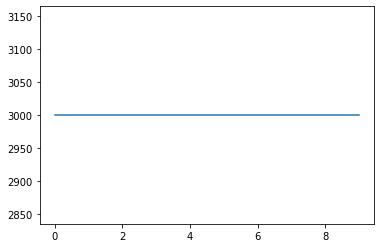

In [34]:
plt.plot(nitertab)
k = np.argmin(nitertab)
print(lamb[k])

In [22]:
k = 0.11
lamb0 = 0.11
mu = 0.1*lamb0
nitermax=3000
step0 = 0.01
ux,uy,CF,step,niter=RecalageDG(original,target,lamb0,mu,nitermax,step0)

iteration : 3  cost function : 991.5489292409991 step : 0.08
iteration : 6  cost function : 991.0173393759147 step : 0.64
iteration : 9  cost function : 988.3526085935334 step : 5.12
iteration : 12  cost function : 984.0229996725819 step : 1.28
iteration : 15  cost function : 982.3414629005548 step : 1.28
iteration : 18  cost function : 981.2187093303119 step : 2.56
iteration : 21  cost function : 979.9880043856464 step : 1.28
iteration : 24  cost function : 978.9382321310683 step : 2.56
iteration : 27  cost function : 977.8715285850824 step : 2.56
iteration : 30  cost function : 976.8853317802957 step : 2.56
iteration : 33  cost function : 975.9147761600632 step : 2.56
iteration : 36  cost function : 974.9892606167771 step : 2.56
iteration : 39  cost function : 974.1292258984022 step : 2.56
iteration : 42  cost function : 973.2638727644619 step : 2.56
iteration : 45  cost function : 972.488770790437 step : 2.56
iteration : 48  cost function : 971.702622262715 step : 1.28
iteration : 5

iteration : 402  cost function : 938.4805019153343 step : 2.56
iteration : 405  cost function : 938.4069287682121 step : 1.28
iteration : 408  cost function : 938.3678112468465 step : 1.28
iteration : 411  cost function : 938.3209988923157 step : 1.28
iteration : 414  cost function : 938.2717696248491 step : 2.56
iteration : 417  cost function : 938.2344007372203 step : 2.56
iteration : 420  cost function : 938.20329079338 step : 2.56
iteration : 423  cost function : 938.1611684570792 step : 2.56
iteration : 426  cost function : 938.1230155853284 step : 2.56
iteration : 429  cost function : 938.067929424493 step : 2.56
iteration : 432  cost function : 938.0161176310564 step : 2.56
iteration : 435  cost function : 937.9594087178415 step : 1.28
iteration : 438  cost function : 937.9189067913499 step : 1.28
iteration : 441  cost function : 937.8674400282417 step : 1.28
iteration : 444  cost function : 937.8178002555305 step : 2.56
iteration : 447  cost function : 937.7806199971626 step : 

In [31]:
res.append([ux,uy,CF,step,niter])

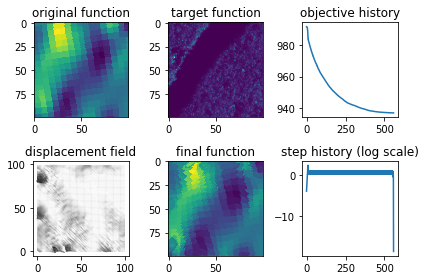

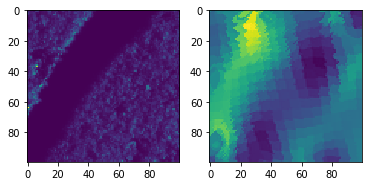

In [25]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(original)
ax[0,0].set_title('original function')
ax[0,1].imshow(target)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(original,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()
fig,ax = plt.subplots(1,2,figsize=(6,6))
ax[0].imshow(target)
ax[1].imshow(interpol(original,ux,uy))

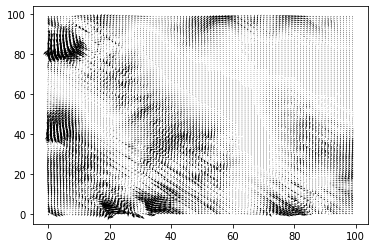

In [24]:
plt.quiver(ux, uy)
plt.show()


In [ ]:
lambk = np.linspace(0,50,20)
muk = np.copy(lambk)
niter1 = np.zeros(20)
step1=0.01
eps1=0.1
nitermax=3000

for i in range(20) :
    ux,uy,CF,step,niter1[i]=RecalageGN(original,target,lambk[i],muk[i],nitermax,step1,eps1)

iteration : 3  cost function : 989.1080716741496 step : 0.08
iteration : 6  cost function : 987.7335002652358 step : 0.64
iteration : 9  cost function : 976.741814494762 step : 5.12
iteration : 12  cost function : 911.4203848681877 step : 40.96
iteration : 15  cost function : 721.8457625575388 step : 327.68
iteration : 18  cost function : 559.408178623704 step : 327.68
iteration : 21  cost function : 489.2086228640021 step : 327.68
iteration : 24  cost function : 470.10958885931376 step : 327.68
iteration : 27  cost function : 461.6942257076386 step : 327.68
iteration : 30  cost function : 457.5368446654909 step : 327.68
iteration : 33  cost function : 455.4239691093503 step : 327.68
iteration : 36  cost function : 454.02095140897205 step : 163.84
iteration : 39  cost function : 437.72648003756956 step : 163.84
iteration : 42  cost function : 434.03328471354496 step : 81.92
iteration : 45  cost function : 433.33163540501386 step : 163.84
iteration : 48  cost function : 432.855405692643

iteration : 342  cost function : 881.8537913134464 step : 2.56
iteration : 345  cost function : 881.2492133938747 step : 1.28
iteration : 348  cost function : 880.358811279628 step : 2.56
iteration : 351  cost function : 879.5626528731227 step : 2.56
iteration : 354  cost function : 878.8090926823453 step : 2.56
iteration : 357  cost function : 878.2651143004489 step : 1.28
iteration : 360  cost function : 877.356766558838 step : 2.56
iteration : 363  cost function : 876.5582254433714 step : 2.56
iteration : 366  cost function : 875.8113267223082 step : 2.56
iteration : 369  cost function : 875.3420456237668 step : 1.28
iteration : 372  cost function : 874.4112221682489 step : 2.56
iteration : 375  cost function : 873.6095586790024 step : 2.56
iteration : 378  cost function : 872.8685828852603 step : 2.56
iteration : 381  cost function : 872.1546962801432 step : 2.56
iteration : 384  cost function : 871.5275380179411 step : 1.28
iteration : 387  cost function : 870.71910613883 step : 2

iteration : 738  cost function : 806.0233506626287 step : 2.56
iteration : 741  cost function : 805.6138568040062 step : 2.56
iteration : 744  cost function : 805.3655989525648 step : 1.28
iteration : 747  cost function : 804.8528273593186 step : 2.56
iteration : 750  cost function : 804.4122768254131 step : 2.56
iteration : 753  cost function : 804.0054850699346 step : 2.56
iteration : 756  cost function : 803.614698026356 step : 2.56
iteration : 759  cost function : 803.2878888892101 step : 1.28
iteration : 762  cost function : 802.8380088223187 step : 2.56
iteration : 765  cost function : 802.4309518267227 step : 2.56
iteration : 768  cost function : 802.0443482384757 step : 2.56
iteration : 771  cost function : 801.7636206147939 step : 1.28
iteration : 774  cost function : 801.3002818522925 step : 2.56
iteration : 777  cost function : 800.8915763737391 step : 2.56
iteration : 780  cost function : 800.5080121181121 step : 2.56
iteration : 783  cost function : 800.2826963710114 step 

iteration : 1128  cost function : 765.7729703190327 step : 2.56
iteration : 1131  cost function : 765.5230768108225 step : 2.56
iteration : 1134  cost function : 765.2830038966594 step : 2.56
iteration : 1137  cost function : 765.0876501930403 step : 1.28
iteration : 1140  cost function : 764.8076517221788 step : 2.56
iteration : 1143  cost function : 764.5550803828658 step : 2.56
iteration : 1146  cost function : 764.3150143668404 step : 2.56
iteration : 1149  cost function : 764.147614216096 step : 1.28
iteration : 1152  cost function : 763.8553706619471 step : 2.56
iteration : 1155  cost function : 763.5989027405552 step : 2.56
iteration : 1158  cost function : 763.358965514551 step : 2.56
iteration : 1161  cost function : 763.2280147713481 step : 1.28
iteration : 1164  cost function : 762.9198035541946 step : 1.28
iteration : 1167  cost function : 762.6579464522443 step : 2.56
iteration : 1170  cost function : 762.4173761839219 step : 2.56
iteration : 1173  cost function : 762.1868

iteration : 1518  cost function : 739.4604211925929 step : 2.56
iteration : 1521  cost function : 739.2981269919214 step : 2.56
iteration : 1524  cost function : 739.1467390288386 step : 2.56
iteration : 1527  cost function : 739.0628532811737 step : 1.28
iteration : 1530  cost function : 738.8710475971492 step : 1.28
iteration : 1533  cost function : 738.7083441017977 step : 2.56
iteration : 1536  cost function : 738.5593845916953 step : 2.56
iteration : 1539  cost function : 738.4172689846405 step : 2.56
iteration : 1542  cost function : 738.3050791965916 step : 1.28
iteration : 1545  cost function : 738.1400188008841 step : 2.56
iteration : 1548  cost function : 737.9925373567702 step : 2.56
iteration : 1551  cost function : 737.8536415587122 step : 2.56
iteration : 1554  cost function : 737.7628098000605 step : 1.28
iteration : 1557  cost function : 737.5933913735222 step : 2.56
iteration : 1560  cost function : 737.4468887816067 step : 2.56
iteration : 1563  cost function : 737.31

iteration : 1908  cost function : 727.1652544656644 step : 1.28
iteration : 1911  cost function : 727.089508012698 step : 1.28
iteration : 1914  cost function : 727.0251845043024 step : 2.56
iteration : 1917  cost function : 726.9662088223147 step : 2.56
iteration : 1920  cost function : 726.9097722523146 step : 2.56
iteration : 1923  cost function : 726.8652201112479 step : 1.28
iteration : 1926  cost function : 726.7989991002992 step : 2.56
iteration : 1929  cost function : 726.7395928711966 step : 2.56
iteration : 1932  cost function : 726.6833861639504 step : 2.56
iteration : 1935  cost function : 726.6461538691138 step : 1.28
iteration : 1938  cost function : 726.5769283701425 step : 2.56
iteration : 1941  cost function : 726.5165756323539 step : 2.56
iteration : 1944  cost function : 726.4603225256923 step : 2.56
iteration : 1947  cost function : 726.4060245039104 step : 2.56
iteration : 1950  cost function : 726.358870809082 step : 1.28
iteration : 1953  cost function : 726.2968

iteration : 2298  cost function : 720.7028478802837 step : 2.56
iteration : 2301  cost function : 720.6748614685399 step : 1.28
iteration : 2304  cost function : 720.6238830410567 step : 2.56
iteration : 2307  cost function : 720.579361944183 step : 2.56
iteration : 2310  cost function : 720.5377970752406 step : 2.56
iteration : 2313  cost function : 720.4977133761809 step : 2.56
iteration : 2316  cost function : 720.4626043045315 step : 1.28
iteration : 2319  cost function : 720.4169891844933 step : 2.56
iteration : 2322  cost function : 720.3751899214162 step : 2.56
iteration : 2325  cost function : 720.3352011073828 step : 2.56
iteration : 2328  cost function : 720.3042382074865 step : 1.28
iteration : 2331  cost function : 720.2569479774862 step : 2.56
iteration : 2334  cost function : 720.2146190627166 step : 2.56
iteration : 2337  cost function : 720.1746571195026 step : 2.56
iteration : 2340  cost function : 720.1489842989305 step : 1.28
iteration : 2343  cost function : 720.099

iteration : 2688  cost function : 715.9181250459882 step : 2.56
iteration : 2691  cost function : 715.8816348046181 step : 2.56
iteration : 2694  cost function : 715.8503715304657 step : 1.28
iteration : 2697  cost function : 715.808244637738 step : 2.56
iteration : 2700  cost function : 715.7697426116474 step : 2.56
iteration : 2703  cost function : 715.7328733535563 step : 2.56
iteration : 2706  cost function : 715.705082942172 step : 1.28
iteration : 2709  cost function : 715.6607913198818 step : 2.56
iteration : 2712  cost function : 715.6212608951369 step : 2.56
iteration : 2715  cost function : 715.5838776050176 step : 2.56
iteration : 2718  cost function : 715.5607410987787 step : 1.28
iteration : 2721  cost function : 715.5137449566574 step : 2.56
iteration : 2724  cost function : 715.4730458234317 step : 2.56
iteration : 2727  cost function : 715.4352227790782 step : 2.56
iteration : 2730  cost function : 715.3987104348463 step : 2.56
iteration : 2733  cost function : 715.3678

iteration : 81  cost function : 963.2588308240918 step : 1.28
iteration : 84  cost function : 962.2470940614102 step : 2.56
iteration : 87  cost function : 961.3792021512501 step : 2.56
iteration : 90  cost function : 960.5557395459867 step : 2.56
iteration : 93  cost function : 960.0098491352599 step : 1.28
iteration : 96  cost function : 958.9901608126563 step : 2.56
iteration : 99  cost function : 958.1190501634215 step : 2.56
iteration : 102  cost function : 957.2987832495713 step : 2.56
iteration : 105  cost function : 956.8087919472449 step : 1.28
iteration : 108  cost function : 955.7716630788123 step : 2.56
iteration : 111  cost function : 954.8966264111049 step : 2.56
iteration : 114  cost function : 954.0799753529654 step : 2.56
iteration : 117  cost function : 953.2972419614985 step : 2.56
iteration : 120  cost function : 952.5950954986922 step : 1.28
iteration : 123  cost function : 951.7048190116599 step : 2.56
iteration : 126  cost function : 950.8817582181439 step : 2.56

iteration : 477  cost function : 855.553651331024 step : 1.28
iteration : 480  cost function : 854.6924969293906 step : 1.28
iteration : 483  cost function : 853.9628101631337 step : 2.56
iteration : 486  cost function : 853.2932519837509 step : 2.56
iteration : 489  cost function : 852.6532069945696 step : 2.56
iteration : 492  cost function : 852.1447760266933 step : 1.28
iteration : 495  cost function : 851.3975053715255 step : 2.56
iteration : 498  cost function : 850.7274014255238 step : 2.56
iteration : 501  cost function : 850.0945848378782 step : 2.56
iteration : 504  cost function : 849.6728443337473 step : 1.28
iteration : 507  cost function : 848.8990245383244 step : 2.56
iteration : 510  cost function : 848.2255748862443 step : 2.56
iteration : 513  cost function : 847.6004716774438 step : 2.56
iteration : 516  cost function : 846.9989661181105 step : 2.56
iteration : 519  cost function : 846.4798318485176 step : 1.28
iteration : 522  cost function : 845.7996333373044 step 

iteration : 873  cost function : 799.369433083763 step : 2.56
iteration : 876  cost function : 799.15725469211 step : 1.28
iteration : 879  cost function : 798.8643556107262 step : 2.56
iteration : 882  cost function : 798.5994096019051 step : 2.56
iteration : 885  cost function : 798.3479703592463 step : 2.56
iteration : 888  cost function : 798.1731360131677 step : 1.28
iteration : 891  cost function : 797.8684706839414 step : 2.56
iteration : 894  cost function : 797.6011232845163 step : 2.56
iteration : 897  cost function : 797.3512395260049 step : 2.56
iteration : 900  cost function : 797.1100493676414 step : 2.56
iteration : 903  cost function : 796.90006073632 step : 1.28
iteration : 906  cost function : 796.6272700055305 step : 2.56
iteration : 909  cost function : 796.3778269730577 step : 2.56
iteration : 912  cost function : 796.1399153562372 step : 2.56
iteration : 915  cost function : 795.9617259975251 step : 1.28
iteration : 918  cost function : 795.6789567181587 step : 2.

iteration : 1260  cost function : 774.3086499781962 step : 1.28
iteration : 1263  cost function : 774.12010376111 step : 2.56
iteration : 1266  cost function : 773.9506219851658 step : 2.56
iteration : 1269  cost function : 773.7900142660723 step : 2.56
iteration : 1272  cost function : 773.6890426743547 step : 1.28
iteration : 1275  cost function : 773.4877411523686 step : 2.56
iteration : 1278  cost function : 773.3126916600356 step : 2.56
iteration : 1281  cost function : 773.1497971537694 step : 2.56
iteration : 1284  cost function : 772.9926313782986 step : 2.56
iteration : 1287  cost function : 772.8620408606514 step : 1.28
iteration : 1290  cost function : 772.6800451861682 step : 2.56
iteration : 1293  cost function : 772.5149712981221 step : 2.56
iteration : 1296  cost function : 772.3578680208796 step : 2.56
iteration : 1299  cost function : 772.2488207887023 step : 1.28
iteration : 1302  cost function : 772.057400308072 step : 2.56
iteration : 1305  cost function : 771.88918

iteration : 1650  cost function : 757.4206029039583 step : 2.56
iteration : 1653  cost function : 757.3263436553538 step : 2.56
iteration : 1656  cost function : 757.2359759867832 step : 2.56
iteration : 1659  cost function : 757.1630060319922 step : 1.28
iteration : 1662  cost function : 757.0584260856647 step : 2.56
iteration : 1665  cost function : 756.9642966717462 step : 2.56
iteration : 1668  cost function : 756.8752616043674 step : 2.56
iteration : 1671  cost function : 756.8168926965623 step : 1.28
iteration : 1674  cost function : 756.7078229076625 step : 2.56
iteration : 1677  cost function : 756.6128840328274 step : 2.56
iteration : 1680  cost function : 756.5246526038205 step : 2.56
iteration : 1683  cost function : 756.4397244987473 step : 2.56
iteration : 1686  cost function : 756.3684009488716 step : 1.28
iteration : 1689  cost function : 756.2710680544735 step : 2.56
iteration : 1692  cost function : 756.1827863035099 step : 2.56
iteration : 1695  cost function : 756.09

iteration : 2037  cost function : 748.4557642837462 step : 2.56
iteration : 2040  cost function : 748.3999569736562 step : 2.56
iteration : 2043  cost function : 748.363098206011 step : 1.28
iteration : 2046  cost function : 748.2941205642358 step : 2.56
iteration : 2049  cost function : 748.2339112855396 step : 2.56
iteration : 2052  cost function : 748.1776702296194 step : 2.56
iteration : 2055  cost function : 748.1233499544705 step : 2.56
iteration : 2058  cost function : 748.0770919265998 step : 1.28
iteration : 2061  cost function : 748.0145253162643 step : 2.56
iteration : 2064  cost function : 747.9574080796976 step : 2.56
iteration : 2067  cost function : 747.9028700742914 step : 2.56
iteration : 2070  cost function : 747.8634493179101 step : 1.28
iteration : 2073  cost function : 747.797440952944 step : 2.56
iteration : 2076  cost function : 747.7389152416072 step : 2.56
iteration : 2079  cost function : 747.6839500940296 step : 2.56
iteration : 2082  cost function : 747.6538

iteration : 2424  cost function : 742.2189594748006 step : 2.56
iteration : 2427  cost function : 742.1949013282717 step : 1.28
iteration : 2430  cost function : 742.1410200678389 step : 1.28
iteration : 2433  cost function : 742.094665116755 step : 2.56
iteration : 2436  cost function : 742.0517675944722 step : 2.56
iteration : 2439  cost function : 742.0105131830006 step : 2.56
iteration : 2442  cost function : 741.9777842047026 step : 1.28
iteration : 2445  cost function : 741.9291622437337 step : 2.56
iteration : 2448  cost function : 741.8853375555032 step : 2.56
iteration : 2451  cost function : 741.8437742489989 step : 2.56
iteration : 2454  cost function : 741.8169607744373 step : 1.28
iteration : 2457  cost function : 741.7652197724381 step : 2.56
iteration : 2460  cost function : 741.7200465523281 step : 2.56
iteration : 2463  cost function : 741.6779467019899 step : 2.56
iteration : 2466  cost function : 741.6372902448013 step : 2.56
iteration : 2469  cost function : 741.603

iteration : 2814  cost function : 737.1809663896952 step : 1.28
iteration : 2817  cost function : 737.1410159547014 step : 2.56
iteration : 2820  cost function : 737.1041999880485 step : 2.56
iteration : 2823  cost function : 737.0688486357876 step : 2.56
iteration : 2826  cost function : 737.0414617811405 step : 1.28
iteration : 2829  cost function : 736.9994258771117 step : 2.56
iteration : 2832  cost function : 736.9616854053703 step : 2.56
iteration : 2835  cost function : 736.9259382368517 step : 2.56
iteration : 2838  cost function : 736.9037723715708 step : 1.28
iteration : 2841  cost function : 736.8588935808768 step : 2.56
iteration : 2844  cost function : 736.819981902418 step : 2.56
iteration : 2847  cost function : 736.7838821861233 step : 2.56
iteration : 2850  cost function : 736.7489865564738 step : 2.56
iteration : 2853  cost function : 736.7201928731675 step : 1.28
iteration : 2856  cost function : 736.6795633210772 step : 2.56
iteration : 2859  cost function : 736.642

iteration : 204  cost function : 933.0283632996362 step : 1.28
iteration : 207  cost function : 932.0948243080728 step : 2.56
iteration : 210  cost function : 931.2532612858835 step : 2.56
iteration : 213  cost function : 930.4517679153976 step : 2.56
iteration : 216  cost function : 929.9085614848243 step : 1.28
iteration : 219  cost function : 928.9127704360214 step : 2.56
iteration : 222  cost function : 928.0369897149815 step : 2.56
iteration : 225  cost function : 927.2133795964896 step : 2.56
iteration : 228  cost function : 926.4116623824522 step : 2.56
iteration : 231  cost function : 925.6935030811783 step : 1.28
iteration : 234  cost function : 924.7709748140066 step : 2.56
iteration : 237  cost function : 923.9164328111195 step : 2.56
iteration : 240  cost function : 923.0917632457666 step : 2.56
iteration : 243  cost function : 922.4258037542181 step : 1.28
iteration : 246  cost function : 921.4471894281796 step : 2.56
iteration : 249  cost function : 920.5592306823431 step

iteration : 600  cost function : 836.3496061488264 step : 1.28
iteration : 603  cost function : 835.7820233189977 step : 2.56
iteration : 606  cost function : 835.278349782276 step : 2.56
iteration : 609  cost function : 834.8061499384389 step : 2.56
iteration : 612  cost function : 834.5354904013544 step : 1.28
iteration : 615  cost function : 833.9422009252244 step : 1.28
iteration : 618  cost function : 833.435702789187 step : 2.56
iteration : 621  cost function : 832.9711053688109 step : 2.56
iteration : 624  cost function : 832.5278513685239 step : 2.56
iteration : 627  cost function : 832.184963302284 step : 1.28
iteration : 630  cost function : 831.6685376372691 step : 2.56
iteration : 633  cost function : 831.2080151012394 step : 2.56
iteration : 636  cost function : 830.7753216080563 step : 2.56
iteration : 639  cost function : 830.5142233800075 step : 1.28
iteration : 642  cost function : 829.9762212194524 step : 1.28
iteration : 645  cost function : 829.5137809902382 step : 

iteration : 993  cost function : 797.5882151736866 step : 2.56
iteration : 996  cost function : 797.3993210796202 step : 2.56
iteration : 999  cost function : 797.2178390745106 step : 2.56
iteration : 1002  cost function : 797.072166737791 step : 1.28
iteration : 1005  cost function : 796.8603227942742 step : 2.56
iteration : 1008  cost function : 796.6695846975714 step : 2.56
iteration : 1011  cost function : 796.4888844408465 step : 2.56
iteration : 1014  cost function : 796.3722904223744 step : 1.28
iteration : 1017  cost function : 796.1490403675667 step : 2.56
iteration : 1020  cost function : 795.9547060133542 step : 2.56
iteration : 1023  cost function : 795.7740401793673 step : 2.56
iteration : 1026  cost function : 795.6000232031175 step : 2.56
iteration : 1029  cost function : 795.4556138453543 step : 1.28
iteration : 1032  cost function : 795.2549029526589 step : 2.56
iteration : 1035  cost function : 795.0730878845712 step : 2.56
iteration : 1038  cost function : 794.900224

iteration : 1380  cost function : 778.2233261606799 step : 2.56
iteration : 1383  cost function : 778.0986548375907 step : 2.56
iteration : 1386  cost function : 777.9786805325548 step : 2.56
iteration : 1389  cost function : 777.8800218006535 step : 1.28
iteration : 1392  cost function : 777.7414042811446 step : 2.56
iteration : 1395  cost function : 777.6158121661723 step : 2.56
iteration : 1398  cost function : 777.4964906909213 step : 2.56
iteration : 1401  cost function : 777.4160374065364 step : 1.28
iteration : 1404  cost function : 777.2700778794577 step : 2.56
iteration : 1407  cost function : 777.1422665519635 step : 2.56
iteration : 1410  cost function : 777.0230010304222 step : 2.56
iteration : 1413  cost function : 776.9079169849384 step : 2.56
iteration : 1416  cost function : 776.8103871337511 step : 1.28
iteration : 1419  cost function : 776.6786090834377 step : 2.56
iteration : 1422  cost function : 776.5586108071942 step : 2.56
iteration : 1425  cost function : 776.44

iteration : 1767  cost function : 765.9714154415936 step : 2.56
iteration : 1770  cost function : 765.8984560489077 step : 2.56
iteration : 1773  cost function : 765.8284244271966 step : 2.56
iteration : 1776  cost function : 765.7735814111712 step : 1.28
iteration : 1779  cost function : 765.691036126153 step : 2.56
iteration : 1782  cost function : 765.6168534039987 step : 2.56
iteration : 1785  cost function : 765.5466691969841 step : 2.56
iteration : 1788  cost function : 765.5031761806326 step : 1.28
iteration : 1791  cost function : 765.4154663192485 step : 2.56
iteration : 1794  cost function : 765.3394037617389 step : 2.56
iteration : 1797  cost function : 765.2687483277119 step : 2.56
iteration : 1800  cost function : 765.2006456222534 step : 2.56
iteration : 1803  cost function : 765.1450719666169 step : 1.28
iteration : 1806  cost function : 765.0657944026514 step : 2.56
iteration : 1809  cost function : 764.9939959943387 step : 2.56
iteration : 1812  cost function : 764.925

iteration : 2157  cost function : 757.6816827324606 step : 2.56
iteration : 2160  cost function : 757.6254478264499 step : 2.56
iteration : 2163  cost function : 757.5771611613154 step : 1.28
iteration : 2166  cost function : 757.5125336568759 step : 2.56
iteration : 2169  cost function : 757.4533994804725 step : 2.56
iteration : 2172  cost function : 757.3968352181172 step : 2.56
iteration : 2175  cost function : 757.3557799590002 step : 1.28
iteration : 2178  cost function : 757.2875038738871 step : 2.56
iteration : 2181  cost function : 757.2268426822659 step : 2.56
iteration : 2184  cost function : 757.169757721696 step : 2.56
iteration : 2187  cost function : 757.1386541923735 step : 1.28
iteration : 2190  cost function : 757.0650824423724 step : 1.28
iteration : 2193  cost function : 757.0020693710342 step : 2.56
iteration : 2196  cost function : 756.9440079372275 step : 2.56
iteration : 2199  cost function : 756.8882921960962 step : 2.56
iteration : 2202  cost function : 756.845

iteration : 2547  cost function : 750.9265437423195 step : 1.28
iteration : 2550  cost function : 750.8667992733748 step : 2.56
iteration : 2553  cost function : 750.8149212408647 step : 2.56
iteration : 2556  cost function : 750.7667188025438 step : 2.56
iteration : 2559  cost function : 750.7202104213083 step : 2.56
iteration : 2562  cost function : 750.6822018342178 step : 1.28
iteration : 2565  cost function : 750.6277883459471 step : 2.56
iteration : 2568  cost function : 750.5784947165662 step : 2.56
iteration : 2571  cost function : 750.5315194260521 step : 2.56
iteration : 2574  cost function : 750.5002041621726 step : 1.28
iteration : 2577  cost function : 750.4423451138348 step : 2.56
iteration : 2580  cost function : 750.3915962379492 step : 2.56
iteration : 2583  cost function : 750.3441384358812 step : 2.56
iteration : 2586  cost function : 750.2982376963142 step : 2.56
iteration : 2589  cost function : 750.25924222353 step : 1.28
iteration : 2592  cost function : 750.2062

iteration : 2934  cost function : 745.3264367804768 step : 1.28
iteration : 2937  cost function : 745.2771684604899 step : 2.56
iteration : 2940  cost function : 745.2332395205324 step : 2.56
iteration : 2943  cost function : 745.191769445645 step : 2.56
iteration : 2946  cost function : 745.1680881674287 step : 1.28
iteration : 2949  cost function : 745.1149160316709 step : 1.28
iteration : 2952  cost function : 745.069080211202 step : 2.56
iteration : 2955  cost function : 745.0266415524235 step : 2.56
iteration : 2958  cost function : 744.9857705769732 step : 2.56
iteration : 2961  cost function : 744.9535191223819 step : 1.28
iteration : 2964  cost function : 744.9051892387373 step : 2.56
iteration : 2967  cost function : 744.8616406385524 step : 2.56
iteration : 2970  cost function : 744.8202871911524 step : 2.56
iteration : 2973  cost function : 744.7941501483197 step : 1.28
iteration : 2976  cost function : 744.742393510399 step : 2.56
iteration : 2979  cost function : 744.69729

iteration : 330  cost function : 900.4564072468319 step : 2.56
iteration : 333  cost function : 899.5834049704163 step : 2.56
iteration : 336  cost function : 898.7438143247653 step : 2.56
iteration : 339  cost function : 898.0845339190203 step : 1.28
iteration : 342  cost function : 897.0927777323136 step : 2.56
iteration : 345  cost function : 896.2012101044886 step : 2.56
iteration : 348  cost function : 895.3567617371767 step : 2.56
iteration : 351  cost function : 894.8234908177764 step : 1.28
iteration : 354  cost function : 893.7715141174905 step : 2.56
iteration : 357  cost function : 892.8584651679209 step : 2.56
iteration : 360  cost function : 892.011359884488 step : 2.56
iteration : 363  cost function : 891.196664788473 step : 2.56
iteration : 366  cost function : 890.5260459333857 step : 1.28
iteration : 369  cost function : 889.5859546087597 step : 2.56
iteration : 372  cost function : 888.7363157867919 step : 2.56
iteration : 375  cost function : 887.9297485238646 step :

iteration : 723  cost function : 823.8903957347106 step : 2.56
iteration : 726  cost function : 823.6889059878764 step : 1.28
iteration : 729  cost function : 823.2807589207168 step : 2.56
iteration : 732  cost function : 822.9291268775263 step : 2.56
iteration : 735  cost function : 822.6049025212957 step : 2.56
iteration : 738  cost function : 822.2945150746747 step : 2.56
iteration : 741  cost function : 822.0473533414014 step : 1.28
iteration : 744  cost function : 821.6880903783472 step : 2.56
iteration : 747  cost function : 821.3659526103228 step : 2.56
iteration : 750  cost function : 821.0620158930382 step : 2.56
iteration : 753  cost function : 820.8708093598368 step : 1.28
iteration : 756  cost function : 820.4959767666929 step : 2.56
iteration : 759  cost function : 820.1717681814314 step : 2.56
iteration : 762  cost function : 819.8719713422591 step : 2.56
iteration : 765  cost function : 819.5845481548079 step : 2.56
iteration : 768  cost function : 819.3518635757147 step

iteration : 1116  cost function : 796.005470016021 step : 1.28
iteration : 1119  cost function : 795.8320791254862 step : 2.56
iteration : 1122  cost function : 795.6768021525097 step : 2.56
iteration : 1125  cost function : 795.5300338069535 step : 2.56
iteration : 1128  cost function : 795.4413459510587 step : 1.28
iteration : 1131  cost function : 795.2567299901002 step : 1.28
iteration : 1134  cost function : 795.0971132074154 step : 2.56
iteration : 1137  cost function : 794.9492514976813 step : 2.56
iteration : 1140  cost function : 794.807061966715 step : 2.56
iteration : 1143  cost function : 794.6931107139237 step : 1.28
iteration : 1146  cost function : 794.5269578868289 step : 2.56
iteration : 1149  cost function : 794.3771915732013 step : 2.56
iteration : 1152  cost function : 794.2352358681694 step : 2.56
iteration : 1155  cost function : 794.1439537488263 step : 1.28
iteration : 1158  cost function : 793.9678173062631 step : 2.56
iteration : 1161  cost function : 793.8143

iteration : 1503  cost function : 780.0828990666174 step : 1.28
iteration : 1506  cost function : 779.9659913132015 step : 2.56
iteration : 1509  cost function : 779.8628245709137 step : 2.56
iteration : 1512  cost function : 779.7660684598629 step : 2.56
iteration : 1515  cost function : 779.6723875130351 step : 2.56
iteration : 1518  cost function : 779.5911599421866 step : 1.28
iteration : 1521  cost function : 779.4841471799596 step : 2.56
iteration : 1524  cost function : 779.3859577397343 step : 2.56
iteration : 1527  cost function : 779.2919005947366 step : 2.56
iteration : 1530  cost function : 779.2224492342816 step : 1.28
iteration : 1533  cost function : 779.1093504136935 step : 2.56
iteration : 1536  cost function : 779.0087557488166 step : 2.56
iteration : 1539  cost function : 778.9140346918552 step : 2.56
iteration : 1542  cost function : 778.8615665570552 step : 1.28
iteration : 1545  cost function : 778.7404004204951 step : 1.28
iteration : 1548  cost function : 778.63

iteration : 1893  cost function : 770.5118099625879 step : 1.28
iteration : 1896  cost function : 770.4465847604959 step : 2.56
iteration : 1899  cost function : 770.3863922731335 step : 2.56
iteration : 1902  cost function : 770.3285685175324 step : 2.56
iteration : 1905  cost function : 770.2840095987917 step : 1.28
iteration : 1908  cost function : 770.2153407495653 step : 2.56
iteration : 1911  cost function : 770.153724799699 step : 2.56
iteration : 1914  cost function : 770.0953798100771 step : 2.56
iteration : 1917  cost function : 770.0601842982989 step : 1.28
iteration : 1920  cost function : 769.9864505176472 step : 1.28
iteration : 1923  cost function : 769.9226078278156 step : 2.56
iteration : 1926  cost function : 769.8634535296871 step : 2.56
iteration : 1929  cost function : 769.8064242849497 step : 2.56
iteration : 1932  cost function : 769.7606488150084 step : 1.28
iteration : 1935  cost function : 769.6937037874403 step : 2.56
iteration : 1938  cost function : 769.633

iteration : 2283  cost function : 763.1266996313252 step : 2.56
iteration : 2286  cost function : 763.0706606127153 step : 2.56
iteration : 2289  cost function : 763.0165359203784 step : 2.56
iteration : 2292  cost function : 762.9720153401731 step : 1.28
iteration : 2295  cost function : 762.9089424027262 step : 2.56
iteration : 2298  cost function : 762.851648636896 step : 2.56
iteration : 2301  cost function : 762.79711863045 step : 2.56
iteration : 2304  cost function : 762.7603660117497 step : 1.28
iteration : 2307  cost function : 762.6932001292531 step : 2.56
iteration : 2310  cost function : 762.6340655691512 step : 2.56
iteration : 2313  cost function : 762.5787253562188 step : 2.56
iteration : 2316  cost function : 762.5251506048243 step : 2.56
iteration : 2319  cost function : 762.4795258490313 step : 1.28
iteration : 2322  cost function : 762.4178388987666 step : 2.56
iteration : 2325  cost function : 762.3614541638849 step : 2.56
iteration : 2328  cost function : 762.30752

iteration : 2673  cost function : 756.4204576168861 step : 2.56
iteration : 2676  cost function : 756.3728586301378 step : 2.56
iteration : 2679  cost function : 756.3327890459025 step : 1.28
iteration : 2682  cost function : 756.27770371819 step : 2.56
iteration : 2685  cost function : 756.2274652539129 step : 2.56
iteration : 2688  cost function : 756.1794132057721 step : 2.56
iteration : 2691  cost function : 756.1457664674901 step : 1.28
iteration : 2694  cost function : 756.0871732142172 step : 2.56
iteration : 2697  cost function : 756.0353973426752 step : 2.56
iteration : 2700  cost function : 755.9866855357711 step : 2.56
iteration : 2703  cost function : 755.9394187392699 step : 2.56
iteration : 2706  cost function : 755.8982281110207 step : 1.28
iteration : 2709  cost function : 755.8440464329533 step : 2.56
iteration : 2712  cost function : 755.7942573944257 step : 2.56
iteration : 2715  cost function : 755.7465441290987 step : 2.56
iteration : 2718  cost function : 755.7111

iteration : 63  cost function : 970.7139937566384 step : 2.56
iteration : 66  cost function : 970.1411667130417 step : 1.28
iteration : 69  cost function : 969.20309448777 step : 2.56
iteration : 72  cost function : 968.367111976697 step : 2.56
iteration : 75  cost function : 967.5918203020924 step : 2.56
iteration : 78  cost function : 967.1124336073565 step : 1.28
iteration : 81  cost function : 966.145681889282 step : 2.56
iteration : 84  cost function : 965.3052455030644 step : 2.56
iteration : 87  cost function : 964.5372917389732 step : 2.56
iteration : 90  cost function : 963.7938837927554 step : 2.56
iteration : 93  cost function : 963.1683301488506 step : 1.28
iteration : 96  cost function : 962.3108323551347 step : 2.56
iteration : 99  cost function : 961.5386445060026 step : 2.56
iteration : 102  cost function : 960.7959939616435 step : 2.56
iteration : 105  cost function : 960.2417917173441 step : 1.28
iteration : 108  cost function : 959.3514278895575 step : 2.56
iteration

iteration : 456  cost function : 870.8970161507033 step : 2.56
iteration : 459  cost function : 870.231521686457 step : 2.56
iteration : 462  cost function : 869.7317504214861 step : 1.28
iteration : 465  cost function : 868.945282635833 step : 2.56
iteration : 468  cost function : 868.2453874183419 step : 2.56
iteration : 471  cost function : 867.5876278903253 step : 2.56
iteration : 474  cost function : 867.2119949743224 step : 1.28
iteration : 477  cost function : 866.3801266183149 step : 1.28
iteration : 480  cost function : 865.6676065053593 step : 2.56
iteration : 483  cost function : 865.0124853660556 step : 2.56
iteration : 486  cost function : 864.3853663121531 step : 2.56
iteration : 489  cost function : 863.900222960676 step : 1.28
iteration : 492  cost function : 863.1635862233504 step : 2.56
iteration : 495  cost function : 862.5048966875298 step : 2.56
iteration : 498  cost function : 861.8841703316377 step : 2.56
iteration : 501  cost function : 861.5109262048702 step : 

iteration : 852  cost function : 815.5192747947575 step : 1.28
iteration : 855  cost function : 815.2486314097655 step : 2.56
iteration : 858  cost function : 815.0075839703154 step : 2.56
iteration : 861  cost function : 814.7809977641843 step : 2.56
iteration : 864  cost function : 814.6507029935602 step : 1.28
iteration : 867  cost function : 814.3650700074471 step : 1.28
iteration : 870  cost function : 814.1202429496627 step : 2.56
iteration : 873  cost function : 813.8950117438966 step : 2.56
iteration : 876  cost function : 813.6795414787485 step : 2.56
iteration : 879  cost function : 813.5132037752895 step : 1.28
iteration : 882  cost function : 813.2601566387058 step : 2.56
iteration : 885  cost function : 813.0340341956913 step : 2.56
iteration : 888  cost function : 812.8208862722347 step : 2.56
iteration : 891  cost function : 812.6939194609722 step : 1.28
iteration : 894  cost function : 812.4269323280396 step : 1.28
iteration : 897  cost function : 812.1971376833018 step

iteration : 1245  cost function : 793.8538047030165 step : 2.56
iteration : 1248  cost function : 793.7236387714076 step : 2.56
iteration : 1251  cost function : 793.5988656650234 step : 2.56
iteration : 1254  cost function : 793.5041624716412 step : 1.28
iteration : 1257  cost function : 793.355359309951 step : 2.56
iteration : 1260  cost function : 793.2223227535659 step : 2.56
iteration : 1263  cost function : 793.0967573597895 step : 2.56
iteration : 1266  cost function : 793.0235388894223 step : 1.28
iteration : 1269  cost function : 792.8641789754199 step : 1.28
iteration : 1272  cost function : 792.7269176457768 step : 2.56
iteration : 1275  cost function : 792.5998872896317 step : 2.56
iteration : 1278  cost function : 792.4776433250175 step : 2.56
iteration : 1281  cost function : 792.3814136617633 step : 1.28
iteration : 1284  cost function : 792.2373666681177 step : 2.56
iteration : 1287  cost function : 792.1076932072338 step : 2.56
iteration : 1290  cost function : 791.984

iteration : 1635  cost function : 780.3160788262658 step : 2.56
iteration : 1638  cost function : 780.2389177377863 step : 2.56
iteration : 1641  cost function : 780.1965017779339 step : 1.28
iteration : 1644  cost function : 780.0980633705791 step : 1.28
iteration : 1647  cost function : 780.0140356530112 step : 2.56
iteration : 1650  cost function : 779.936850886185 step : 2.56
iteration : 1653  cost function : 779.8630585026863 step : 2.56
iteration : 1656  cost function : 779.8073588489044 step : 1.28
iteration : 1659  cost function : 779.720027628186 step : 2.56
iteration : 1662  cost function : 779.6421859828778 step : 2.56
iteration : 1665  cost function : 779.5689193062764 step : 2.56
iteration : 1668  cost function : 779.5271051929328 step : 1.28
iteration : 1671  cost function : 779.4344244070874 step : 1.28
iteration : 1674  cost function : 779.3548698164377 step : 2.56
iteration : 1677  cost function : 779.2815978916914 step : 2.56
iteration : 1680  cost function : 779.2114

iteration : 2022  cost function : 772.6712798338359 step : 2.56
iteration : 2025  cost function : 772.6188434669862 step : 2.56
iteration : 2028  cost function : 772.5684212855397 step : 2.56
iteration : 2031  cost function : 772.5295631916255 step : 1.28
iteration : 2034  cost function : 772.4697710168801 step : 2.56
iteration : 2037  cost function : 772.4160844087943 step : 2.56
iteration : 2040  cost function : 772.3651948122714 step : 2.56
iteration : 2043  cost function : 772.3345889091535 step : 1.28
iteration : 2046  cost function : 772.2703277565289 step : 1.28
iteration : 2049  cost function : 772.2147358903694 step : 2.56
iteration : 2052  cost function : 772.1631318059757 step : 2.56
iteration : 2055  cost function : 772.113395746522 step : 2.56
iteration : 2058  cost function : 772.0735017875892 step : 1.28
iteration : 2061  cost function : 772.0150135905719 step : 2.56
iteration : 2064  cost function : 771.9621810510407 step : 2.56
iteration : 2067  cost function : 771.911

iteration : 2409  cost function : 766.2179521785202 step : 2.56
iteration : 2412  cost function : 766.1668056869676 step : 2.56
iteration : 2415  cost function : 766.117559380047 step : 2.56
iteration : 2418  cost function : 766.0791987226189 step : 1.28
iteration : 2421  cost function : 766.0208544991492 step : 2.56
iteration : 2424  cost function : 765.9683042218958 step : 2.56
iteration : 2427  cost function : 765.9184307427156 step : 2.56
iteration : 2430  cost function : 765.8878034402355 step : 1.28
iteration : 2433  cost function : 765.8249202888483 step : 2.56
iteration : 2436  cost function : 765.7703186895483 step : 2.56
iteration : 2439  cost function : 765.7195459680693 step : 2.56
iteration : 2442  cost function : 765.6705477488413 step : 2.56
iteration : 2445  cost function : 765.630688346691 step : 1.28
iteration : 2448  cost function : 765.5731390508306 step : 2.56
iteration : 2451  cost function : 765.5209655073178 step : 2.56
iteration : 2454  cost function : 765.4713

iteration : 2799  cost function : 759.943889011327 step : 2.56
iteration : 2802  cost function : 759.898972472427 step : 2.56
iteration : 2805  cost function : 759.8653942387449 step : 1.28
iteration : 2808  cost function : 759.8116527651891 step : 2.56
iteration : 2811  cost function : 759.7636354570728 step : 2.56
iteration : 2814  cost function : 759.7182972135005 step : 2.56
iteration : 2817  cost function : 759.6924519457891 step : 1.28
iteration : 2820  cost function : 759.634492998808 step : 1.28
iteration : 2823  cost function : 759.5845944436979 step : 2.56
iteration : 2826  cost function : 759.5384882468477 step : 2.56
iteration : 2829  cost function : 759.4940962948749 step : 2.56
iteration : 2832  cost function : 759.4594814356587 step : 1.28
iteration : 2835  cost function : 759.4068638488072 step : 2.56
iteration : 2838  cost function : 759.3595481465339 step : 2.56
iteration : 2841  cost function : 759.3146891560035 step : 2.56
iteration : 2844  cost function : 759.28721

iteration : 192  cost function : 939.3726164437181 step : 1.28
iteration : 195  cost function : 938.4727777677368 step : 2.56
iteration : 198  cost function : 937.6880139992245 step : 2.56
iteration : 201  cost function : 936.955931508104 step : 2.56
iteration : 204  cost function : 936.2457423973715 step : 2.56
iteration : 207  cost function : 935.6451171643804 step : 1.28
iteration : 210  cost function : 934.8211735485784 step : 2.56
iteration : 213  cost function : 934.0684819057747 step : 2.56
iteration : 216  cost function : 933.3486156914795 step : 2.56
iteration : 219  cost function : 932.8307589196502 step : 1.28
iteration : 222  cost function : 931.9542550242635 step : 2.56
iteration : 225  cost function : 931.1752842533242 step : 2.56
iteration : 228  cost function : 930.4411107182152 step : 2.56
iteration : 231  cost function : 930.0370720501691 step : 1.28
iteration : 234  cost function : 929.0877105026439 step : 1.28
iteration : 237  cost function : 928.2732538545007 step 

iteration : 585  cost function : 848.4274893106231 step : 2.56
iteration : 588  cost function : 847.9352502670976 step : 2.56
iteration : 591  cost function : 847.4619473243589 step : 2.56
iteration : 594  cost function : 847.0600504881818 step : 1.28
iteration : 597  cost function : 846.5229765832444 step : 2.56
iteration : 600  cost function : 846.0350143115428 step : 2.56
iteration : 603  cost function : 845.5714837283192 step : 2.56
iteration : 606  cost function : 845.2460074936132 step : 1.28
iteration : 609  cost function : 844.6890322916599 step : 2.56
iteration : 612  cost function : 844.1992644890465 step : 2.56
iteration : 615  cost function : 843.742287514299 step : 2.56
iteration : 618  cost function : 843.3024691383193 step : 2.56
iteration : 621  cost function : 842.9255538023548 step : 1.28
iteration : 624  cost function : 842.4280511780561 step : 2.56
iteration : 627  cost function : 841.9749910755269 step : 2.56
iteration : 630  cost function : 841.5443972510794 step 

iteration : 981  cost function : 809.3763725782758 step : 2.56
iteration : 984  cost function : 809.2322796778391 step : 1.28
iteration : 987  cost function : 809.0317740291774 step : 2.56
iteration : 990  cost function : 808.8500990334475 step : 2.56
iteration : 993  cost function : 808.677555846336 step : 2.56
iteration : 996  cost function : 808.5613060286572 step : 1.28
iteration : 999  cost function : 808.3505646528599 step : 2.56
iteration : 1002  cost function : 808.1659246977508 step : 2.56
iteration : 1005  cost function : 807.9936990462802 step : 2.56
iteration : 1008  cost function : 807.8275572641188 step : 2.56
iteration : 1011  cost function : 807.6874677997121 step : 1.28
iteration : 1014  cost function : 807.4968159541799 step : 2.56
iteration : 1017  cost function : 807.3233479342879 step : 2.56
iteration : 1020  cost function : 807.1582366136723 step : 2.56
iteration : 1023  cost function : 807.0435284807588 step : 1.28
iteration : 1026  cost function : 806.8437035897

iteration : 1371  cost function : 791.6064920246181 step : 1.28
iteration : 1374  cost function : 791.4690359376241 step : 2.56
iteration : 1377  cost function : 791.3487833607495 step : 2.56
iteration : 1380  cost function : 791.2365847673767 step : 2.56
iteration : 1383  cost function : 791.1283186456366 step : 2.56
iteration : 1386  cost function : 791.0380427009488 step : 1.28
iteration : 1389  cost function : 790.9128408084557 step : 2.56
iteration : 1392  cost function : 790.7989026842678 step : 2.56
iteration : 1395  cost function : 790.690367947621 step : 2.56
iteration : 1398  cost function : 790.6158228430828 step : 1.28
iteration : 1401  cost function : 790.4831251296772 step : 2.56
iteration : 1404  cost function : 790.3663085417016 step : 2.56
iteration : 1407  cost function : 790.257013794945 step : 2.56
iteration : 1410  cost function : 790.1512594175583 step : 2.56
iteration : 1413  cost function : 790.0608641430524 step : 1.28
iteration : 1416  cost function : 789.9396

iteration : 1761  cost function : 780.3187916454815 step : 1.28
iteration : 1764  cost function : 780.2454119284422 step : 2.56
iteration : 1767  cost function : 780.1801227261266 step : 2.56
iteration : 1770  cost function : 780.1186747937738 step : 2.56
iteration : 1773  cost function : 780.0845648502151 step : 1.28
iteration : 1776  cost function : 780.0061872022972 step : 1.28
iteration : 1779  cost function : 779.9391482371012 step : 2.56
iteration : 1782  cost function : 779.8774412600296 step : 2.56
iteration : 1785  cost function : 779.818328160315 step : 2.56
iteration : 1788  cost function : 779.7733804614321 step : 1.28
iteration : 1791  cost function : 779.7033373676089 step : 2.56
iteration : 1794  cost function : 779.6407052131729 step : 2.56
iteration : 1797  cost function : 779.5816098873636 step : 2.56
iteration : 1800  cost function : 779.5472411225398 step : 1.28
iteration : 1803  cost function : 779.4723618760448 step : 1.28
iteration : 1806  cost function : 779.407

iteration : 2148  cost function : 773.7595809341321 step : 1.28
iteration : 2151  cost function : 773.701321616646 step : 1.28
iteration : 2154  cost function : 773.6512282778127 step : 2.56
iteration : 2157  cost function : 773.604919831862 step : 2.56
iteration : 2160  cost function : 773.5603456805965 step : 2.56
iteration : 2163  cost function : 773.5256914289939 step : 1.28
iteration : 2166  cost function : 773.47277847457 step : 2.56
iteration : 2169  cost function : 773.4251466441299 step : 2.56
iteration : 2172  cost function : 773.3800491496647 step : 2.56
iteration : 2175  cost function : 773.352608074412 step : 1.28
iteration : 2178  cost function : 773.2956770836333 step : 2.56
iteration : 2181  cost function : 773.2462543754881 step : 2.56
iteration : 2184  cost function : 773.2003318057147 step : 2.56
iteration : 2187  cost function : 773.1559915692391 step : 2.56
iteration : 2190  cost function : 773.1202643191373 step : 1.28
iteration : 2193  cost function : 773.0682429

iteration : 2538  cost function : 767.9436498984326 step : 1.28
iteration : 2541  cost function : 767.8936668117392 step : 2.56
iteration : 2544  cost function : 767.8476690121903 step : 2.56
iteration : 2547  cost function : 767.8034952301833 step : 2.56
iteration : 2550  cost function : 767.7705266952241 step : 1.28
iteration : 2553  cost function : 767.7174989532581 step : 2.56
iteration : 2556  cost function : 767.670079679898 step : 2.56
iteration : 2559  cost function : 767.6252413853059 step : 2.56
iteration : 2562  cost function : 767.5997821869714 step : 1.28
iteration : 2565  cost function : 767.5423551013984 step : 1.28
iteration : 2568  cost function : 767.4928918919456 step : 2.56
iteration : 2571  cost function : 767.4471162296327 step : 2.56
iteration : 2574  cost function : 767.40304081442 step : 2.56
iteration : 2577  cost function : 767.3687404092615 step : 1.28
iteration : 2580  cost function : 767.3163956116416 step : 2.56
iteration : 2583  cost function : 767.26927

iteration : 2928  cost function : 762.2064018084234 step : 2.56
iteration : 2931  cost function : 762.1622231176957 step : 2.56
iteration : 2934  cost function : 762.1200794008229 step : 2.56
iteration : 2937  cost function : 762.0912253480847 step : 1.28
iteration : 2940  cost function : 762.0395835340418 step : 2.56
iteration : 2943  cost function : 761.9940982330534 step : 2.56
iteration : 2946  cost function : 761.9514294411717 step : 2.56
iteration : 2949  cost function : 761.9100796515694 step : 2.56
iteration : 2952  cost function : 761.8746843422489 step : 1.28
iteration : 2955  cost function : 761.8271579431166 step : 2.56
iteration : 2958  cost function : 761.7836561891249 step : 2.56
iteration : 2961  cost function : 761.7419987285617 step : 2.56
iteration : 2964  cost function : 761.7121521990715 step : 1.28
iteration : 2967  cost function : 761.6616430417895 step : 2.56
iteration : 2970  cost function : 761.616824594059 step : 2.56
iteration : 2973  cost function : 761.574

iteration : 324  cost function : 908.114219376818 step : 2.56
iteration : 327  cost function : 907.33713906735 step : 2.56
iteration : 330  cost function : 906.5884861696591 step : 2.56
iteration : 333  cost function : 906.0096044544338 step : 1.28
iteration : 336  cost function : 905.1141630741084 step : 2.56
iteration : 339  cost function : 904.3087627853273 step : 2.56
iteration : 342  cost function : 903.5444770613077 step : 2.56
iteration : 345  cost function : 903.0751316786437 step : 1.28
iteration : 348  cost function : 902.1082158590254 step : 2.56
iteration : 351  cost function : 901.2672076335652 step : 2.56
iteration : 354  cost function : 900.4841223514312 step : 2.56
iteration : 357  cost function : 899.7269256877556 step : 2.56
iteration : 360  cost function : 899.107537899592 step : 1.28
iteration : 363  cost function : 898.2211666926218 step : 2.56
iteration : 366  cost function : 897.4177991308081 step : 2.56
iteration : 369  cost function : 896.6528210114867 step : 2

iteration : 720  cost function : 832.4935965891024 step : 2.56
iteration : 723  cost function : 832.218671236736 step : 1.28
iteration : 726  cost function : 831.8380531666938 step : 2.56
iteration : 729  cost function : 831.49426449615 step : 2.56
iteration : 732  cost function : 831.1688987905745 step : 2.56
iteration : 735  cost function : 830.9524639667168 step : 1.28
iteration : 738  cost function : 830.5571161071447 step : 2.56
iteration : 741  cost function : 830.212504375955 step : 2.56
iteration : 744  cost function : 829.8926411056368 step : 2.56
iteration : 747  cost function : 829.5855132608785 step : 2.56
iteration : 750  cost function : 829.3310905722883 step : 1.28
iteration : 753  cost function : 828.9799272007255 step : 2.56
iteration : 756  cost function : 828.6622324969248 step : 2.56
iteration : 759  cost function : 828.3611908405828 step : 2.56
iteration : 762  cost function : 828.1589855652337 step : 1.28
iteration : 765  cost function : 827.7929655117699 step : 2

iteration : 1110  cost function : 804.4838021509144 step : 2.56
iteration : 1113  cost function : 804.3662137376396 step : 1.28
iteration : 1116  cost function : 804.2007095274705 step : 2.56
iteration : 1119  cost function : 804.0506944767177 step : 2.56
iteration : 1122  cost function : 803.9081423555745 step : 2.56
iteration : 1125  cost function : 803.8130590860908 step : 1.28
iteration : 1128  cost function : 803.6380414593542 step : 2.56
iteration : 1131  cost function : 803.4846701686854 step : 2.56
iteration : 1134  cost function : 803.3416614922177 step : 2.56
iteration : 1137  cost function : 803.2036852543814 step : 2.56
iteration : 1140  cost function : 803.0879856427787 step : 1.28
iteration : 1143  cost function : 802.9292813739278 step : 2.56
iteration : 1146  cost function : 802.78491406034 step : 2.56
iteration : 1149  cost function : 802.6473802657881 step : 2.56
iteration : 1152  cost function : 802.5524564537084 step : 1.28
iteration : 1155  cost function : 802.3849

iteration : 1500  cost function : 789.321654237189 step : 1.28
iteration : 1503  cost function : 789.2036707318119 step : 2.56
iteration : 1506  cost function : 789.1013995453363 step : 2.56
iteration : 1509  cost function : 789.0065564551526 step : 2.56
iteration : 1512  cost function : 788.9152720210207 step : 2.56
iteration : 1515  cost function : 788.8419459332174 step : 1.28
iteration : 1518  cost function : 788.735400433924 step : 2.56
iteration : 1521  cost function : 788.6392970430182 step : 2.56
iteration : 1524  cost function : 788.5481585941728 step : 2.56
iteration : 1527  cost function : 788.4899590254969 step : 1.28
iteration : 1530  cost function : 788.3769809959877 step : 2.56
iteration : 1533  cost function : 788.2786877940781 step : 2.56
iteration : 1536  cost function : 788.1873313104923 step : 2.56
iteration : 1539  cost function : 788.0994127314847 step : 2.56
iteration : 1542  cost function : 788.0275179092042 step : 1.28
iteration : 1545  cost function : 787.9256

iteration : 1890  cost function : 780.1523384647015 step : 1.28
iteration : 1893  cost function : 780.0874552908172 step : 2.56
iteration : 1896  cost function : 780.030392439406 step : 2.56
iteration : 1899  cost function : 779.9769856332587 step : 2.56
iteration : 1902  cost function : 779.925396371882 step : 2.56
iteration : 1905  cost function : 779.8815802323295 step : 1.28
iteration : 1908  cost function : 779.8224476775788 step : 2.56
iteration : 1911  cost function : 779.7684810278645 step : 2.56
iteration : 1914  cost function : 779.7169873607736 step : 2.56
iteration : 1917  cost function : 779.6806370337101 step : 1.28
iteration : 1920  cost function : 779.6182678742415 step : 2.56
iteration : 1923  cost function : 779.5631793329186 step : 2.56
iteration : 1926  cost function : 779.5114743942231 step : 2.56
iteration : 1929  cost function : 779.4614684292969 step : 2.56
iteration : 1932  cost function : 779.4182212429787 step : 1.28
iteration : 1935  cost function : 779.3612

iteration : 2280  cost function : 774.2607835628676 step : 1.28
iteration : 2283  cost function : 774.2139925519643 step : 2.56
iteration : 2286  cost function : 774.1711200896996 step : 2.56
iteration : 2289  cost function : 774.1300657967352 step : 2.56
iteration : 2292  cost function : 774.1006311355156 step : 1.28
iteration : 2295  cost function : 774.0507715883704 step : 2.56
iteration : 2298  cost function : 774.0065408973992 step : 2.56
iteration : 2301  cost function : 773.9648759146852 step : 2.56
iteration : 2304  cost function : 773.9243956701138 step : 2.56
iteration : 2307  cost function : 773.8888109953587 step : 1.28
iteration : 2310  cost function : 773.8425915094342 step : 2.56
iteration : 2313  cost function : 773.8000305254924 step : 2.56
iteration : 2316  cost function : 773.7591953239113 step : 2.56
iteration : 2319  cost function : 773.7285854735378 step : 1.28
iteration : 2322  cost function : 773.6795517919402 step : 2.56
iteration : 2325  cost function : 773.63

iteration : 2670  cost function : 768.9470876298396 step : 2.56
iteration : 2673  cost function : 768.9041360261612 step : 2.56
iteration : 2676  cost function : 768.8632769504841 step : 2.56
iteration : 2679  cost function : 768.8367818200151 step : 1.28
iteration : 2682  cost function : 768.7858514445901 step : 2.56
iteration : 2685  cost function : 768.7411877271718 step : 2.56
iteration : 2688  cost function : 768.6994657221327 step : 2.56
iteration : 2691  cost function : 768.659099616616 step : 2.56
iteration : 2694  cost function : 768.6254656486994 step : 1.28
iteration : 2697  cost function : 768.578483504493 step : 2.56
iteration : 2700  cost function : 768.535651200447 step : 2.56
iteration : 2703  cost function : 768.4947029194 step : 2.56
iteration : 2706  cost function : 768.4665804318237 step : 1.28
iteration : 2709  cost function : 768.4162556515079 step : 2.56
iteration : 2712  cost function : 768.3718609722439 step : 2.56
iteration : 2715  cost function : 768.33019667

iteration : 57  cost function : 972.9126902741757 step : 2.56
iteration : 60  cost function : 972.1281305958578 step : 2.56
iteration : 63  cost function : 971.6543840656129 step : 1.28
iteration : 66  cost function : 970.6707990809509 step : 2.56
iteration : 69  cost function : 969.8330809088902 step : 2.56
iteration : 72  cost function : 969.0540917116347 step : 2.56
iteration : 75  cost function : 968.3091928991857 step : 2.56
iteration : 78  cost function : 967.6834181479529 step : 1.28
iteration : 81  cost function : 966.8271910300663 step : 2.56
iteration : 84  cost function : 966.0468686478256 step : 2.56
iteration : 87  cost function : 965.3099504557756 step : 2.56
iteration : 90  cost function : 964.7824599907359 step : 1.28
iteration : 93  cost function : 963.8957889539068 step : 2.56
iteration : 96  cost function : 963.1073922351776 step : 2.56
iteration : 99  cost function : 962.3717738468271 step : 2.56
iteration : 102  cost function : 961.9641613872567 step : 1.28
iterati

iteration : 453  cost function : 878.0532148185724 step : 2.56
iteration : 456  cost function : 877.3632127060847 step : 2.56
iteration : 459  cost function : 876.706003689784 step : 2.56
iteration : 462  cost function : 876.2328859904267 step : 1.28
iteration : 465  cost function : 875.4459369183905 step : 2.56
iteration : 468  cost function : 874.7502359608906 step : 2.56
iteration : 471  cost function : 874.0988691086724 step : 2.56
iteration : 474  cost function : 873.4699401994943 step : 2.56
iteration : 477  cost function : 872.9215690742416 step : 1.28
iteration : 480  cost function : 872.2117767085864 step : 2.56
iteration : 483  cost function : 871.5627510544178 step : 2.56
iteration : 486  cost function : 870.9441180104975 step : 2.56
iteration : 489  cost function : 870.4903952485571 step : 1.28
iteration : 492  cost function : 869.7551580139539 step : 2.56
iteration : 495  cost function : 869.1038153285577 step : 2.56
iteration : 498  cost function : 868.4936248315137 step 

iteration : 846  cost function : 822.18438020144 step : 2.56
iteration : 849  cost function : 821.9426349651535 step : 2.56
iteration : 852  cost function : 821.7872833686804 step : 1.28
iteration : 855  cost function : 821.4899729869722 step : 2.56
iteration : 858  cost function : 821.2315774025399 step : 2.56
iteration : 861  cost function : 820.9919880966778 step : 2.56
iteration : 864  cost function : 820.7619316064267 step : 2.56
iteration : 867  cost function : 820.5747248665542 step : 1.28
iteration : 870  cost function : 820.3097834223904 step : 2.56
iteration : 873  cost function : 820.0708180911515 step : 2.56
iteration : 876  cost function : 819.844680967235 step : 2.56
iteration : 879  cost function : 819.6978118796278 step : 1.28
iteration : 882  cost function : 819.420457300602 step : 2.56
iteration : 885  cost function : 819.1791542672225 step : 2.56
iteration : 888  cost function : 818.955203315033 step : 2.56
iteration : 891  cost function : 818.7402138751194 step : 2.

iteration : 1236  cost function : 800.2514047047191 step : 2.56
iteration : 1239  cost function : 800.1285094806454 step : 2.56
iteration : 1242  cost function : 800.0454254111544 step : 1.28
iteration : 1245  cost function : 799.8952323344589 step : 2.56
iteration : 1248  cost function : 799.7634197052195 step : 2.56
iteration : 1251  cost function : 799.6403790673533 step : 2.56
iteration : 1254  cost function : 799.5216668322861 step : 2.56
iteration : 1257  cost function : 799.4216492573127 step : 1.28
iteration : 1260  cost function : 799.2854042636573 step : 2.56
iteration : 1263  cost function : 799.1613939987784 step : 2.56
iteration : 1266  cost function : 799.0431544877562 step : 2.56
iteration : 1269  cost function : 798.9611110925345 step : 1.28
iteration : 1272  cost function : 798.8174545342108 step : 2.56
iteration : 1275  cost function : 798.6909046842079 step : 2.56
iteration : 1278  cost function : 798.5723422622133 step : 2.56
iteration : 1281  cost function : 798.45

iteration : 1623  cost function : 787.4029198244737 step : 2.56
iteration : 1626  cost function : 787.3242370714713 step : 2.56
iteration : 1629  cost function : 787.248894665136 step : 2.56
iteration : 1632  cost function : 787.1915688704603 step : 1.28
iteration : 1635  cost function : 787.1024427424421 step : 2.56
iteration : 1638  cost function : 787.0229182196927 step : 2.56
iteration : 1641  cost function : 786.9480303745413 step : 2.56
iteration : 1644  cost function : 786.9049949802649 step : 1.28
iteration : 1647  cost function : 786.8102347992608 step : 1.28
iteration : 1650  cost function : 786.7289424724563 step : 2.56
iteration : 1653  cost function : 786.6540848481787 step : 2.56
iteration : 1656  cost function : 786.5824299284644 step : 2.56
iteration : 1659  cost function : 786.5272602025419 step : 1.28
iteration : 1662  cost function : 786.4429003910334 step : 2.56
iteration : 1665  cost function : 786.3674214977882 step : 2.56
iteration : 1668  cost function : 786.296

iteration : 2013  cost function : 779.8679789275287 step : 2.56
iteration : 2016  cost function : 779.8208353104793 step : 2.56
iteration : 2019  cost function : 779.7754094059849 step : 2.56
iteration : 2022  cost function : 779.7384992628824 step : 1.28
iteration : 2025  cost function : 779.6856270653063 step : 2.56
iteration : 2028  cost function : 779.6377961168765 step : 2.56
iteration : 2031  cost function : 779.5923292895585 step : 2.56
iteration : 2034  cost function : 779.5626661661604 step : 1.28
iteration : 2037  cost function : 779.5064660731638 step : 2.56
iteration : 2040  cost function : 779.4573517789185 step : 2.56
iteration : 2043  cost function : 779.4115356416019 step : 2.56
iteration : 2046  cost function : 779.3673054377236 step : 2.56
iteration : 2049  cost function : 779.3306724566368 step : 1.28
iteration : 2052  cost function : 779.2794771152516 step : 2.56
iteration : 2055  cost function : 779.2329094369604 step : 2.56
iteration : 2058  cost function : 779.18

iteration : 2403  cost function : 774.4757622007955 step : 2.56
iteration : 2406  cost function : 774.4370215657292 step : 2.56
iteration : 2409  cost function : 774.4113142668381 step : 1.28
iteration : 2412  cost function : 774.3634922720008 step : 2.56
iteration : 2415  cost function : 774.3215213989187 step : 2.56
iteration : 2418  cost function : 774.2822378912581 step : 2.56
iteration : 2421  cost function : 774.2442198252467 step : 2.56
iteration : 2424  cost function : 774.2122871185597 step : 1.28
iteration : 2427  cost function : 774.1683103078776 step : 2.56
iteration : 2430  cost function : 774.1281475884068 step : 2.56
iteration : 2433  cost function : 774.0897672586063 step : 2.56
iteration : 2436  cost function : 774.0630919547662 step : 1.28
iteration : 2439  cost function : 774.0161847938423 step : 2.56
iteration : 2442  cost function : 773.9747087929678 step : 2.56
iteration : 2445  cost function : 773.935770913053 step : 2.56
iteration : 2448  cost function : 773.897

iteration : 2793  cost function : 769.5481388028358 step : 2.56
iteration : 2796  cost function : 769.5274504089284 step : 1.28
iteration : 2799  cost function : 769.4781399198035 step : 1.28
iteration : 2802  cost function : 769.4358553210509 step : 2.56
iteration : 2805  cost function : 769.396827868021 step : 2.56
iteration : 2808  cost function : 769.3593236166374 step : 2.56
iteration : 2811  cost function : 769.3308151402778 step : 1.28
iteration : 2814  cost function : 769.2859787843953 step : 2.56
iteration : 2817  cost function : 769.2457706499804 step : 2.56
iteration : 2820  cost function : 769.207724655897 step : 2.56
iteration : 2823  cost function : 769.1855523720424 step : 1.28
iteration : 2826  cost function : 769.1370621182002 step : 1.28
iteration : 2829  cost function : 769.0951539910756 step : 2.56
iteration : 2832  cost function : 769.0563128516308 step : 2.56
iteration : 2835  cost function : 769.0189320218216 step : 2.56
iteration : 2838  cost function : 768.9895

iteration : 183  cost function : 942.865475587889 step : 1.28
iteration : 186  cost function : 941.9875400005262 step : 2.56
iteration : 189  cost function : 941.2271157015604 step : 2.56
iteration : 192  cost function : 940.5199712605959 step : 2.56
iteration : 195  cost function : 939.8386603927337 step : 2.56
iteration : 198  cost function : 939.2777688614148 step : 1.28
iteration : 201  cost function : 938.4849953710915 step : 2.56
iteration : 204  cost function : 937.7658530665525 step : 2.56
iteration : 207  cost function : 937.0816690959912 step : 2.56
iteration : 210  cost function : 936.6165492521404 step : 1.28
iteration : 213  cost function : 935.7758024299351 step : 2.56
iteration : 216  cost function : 935.0359304649423 step : 2.56
iteration : 219  cost function : 934.3427481200483 step : 2.56
iteration : 222  cost function : 933.6707062408408 step : 2.56
iteration : 225  cost function : 933.091045768473 step : 1.28
iteration : 228  cost function : 932.316006728824 step : 

iteration : 576  cost function : 855.8425951260318 step : 2.56
iteration : 579  cost function : 855.3313687326681 step : 2.56
iteration : 582  cost function : 854.84151873479 step : 2.56
iteration : 585  cost function : 854.4569260925414 step : 1.28
iteration : 588  cost function : 853.8852250263794 step : 2.56
iteration : 591  cost function : 853.3730955795847 step : 2.56
iteration : 594  cost function : 852.8900437443812 step : 2.56
iteration : 597  cost function : 852.5959394771237 step : 1.28
iteration : 600  cost function : 851.9952723581024 step : 1.28
iteration : 603  cost function : 851.4776591536753 step : 2.56
iteration : 606  cost function : 851.0001366784761 step : 2.56
iteration : 609  cost function : 850.543189857795 step : 2.56
iteration : 612  cost function : 850.1824025556468 step : 1.28
iteration : 615  cost function : 849.6518613875301 step : 2.56
iteration : 618  cost function : 849.1761678532399 step : 2.56
iteration : 621  cost function : 848.7279918031549 step : 

iteration : 972  cost function : 814.5881441418262 step : 2.56
iteration : 975  cost function : 814.458009776747 step : 1.28
iteration : 978  cost function : 814.2327713697465 step : 2.56
iteration : 981  cost function : 814.0347795005164 step : 2.56
iteration : 984  cost function : 813.8496296078299 step : 2.56
iteration : 987  cost function : 813.6709751484644 step : 2.56
iteration : 990  cost function : 813.5180335568529 step : 1.28
iteration : 993  cost function : 813.3145002501045 step : 2.56
iteration : 996  cost function : 813.1288788700095 step : 2.56
iteration : 999  cost function : 812.9520423843164 step : 2.56
iteration : 1002  cost function : 812.8265545263233 step : 1.28
iteration : 1005  cost function : 812.6136408857312 step : 2.56
iteration : 1008  cost function : 812.4256812996439 step : 2.56
iteration : 1011  cost function : 812.2497628794885 step : 2.56
iteration : 1014  cost function : 812.0797762022702 step : 2.56
iteration : 1017  cost function : 811.9329706842982

iteration : 1362  cost function : 796.6146814351475 step : 2.56
iteration : 1365  cost function : 796.5368956476318 step : 1.28
iteration : 1368  cost function : 796.4125066017673 step : 2.56
iteration : 1371  cost function : 796.301581240537 step : 2.56
iteration : 1374  cost function : 796.197024666002 step : 2.56
iteration : 1377  cost function : 796.1385857918502 step : 1.28
iteration : 1380  cost function : 796.0050216113835 step : 1.28
iteration : 1383  cost function : 795.89064012569 step : 2.56
iteration : 1386  cost function : 795.7851999757095 step : 2.56
iteration : 1389  cost function : 795.6839995447955 step : 2.56
iteration : 1392  cost function : 795.6066247003492 step : 1.28
iteration : 1395  cost function : 795.4867005379393 step : 2.56
iteration : 1398  cost function : 795.3793651049225 step : 2.56
iteration : 1401  cost function : 795.2779372592481 step : 2.56
iteration : 1404  cost function : 795.2185897687403 step : 1.28
iteration : 1407  cost function : 795.090089

iteration : 1749  cost function : 785.8355802296094 step : 2.56
iteration : 1752  cost function : 785.7763707627155 step : 2.56
iteration : 1755  cost function : 785.7309563351466 step : 1.28
iteration : 1758  cost function : 785.6611733486608 step : 2.56
iteration : 1761  cost function : 785.5987931782959 step : 2.56
iteration : 1764  cost function : 785.5399964615414 step : 2.56
iteration : 1767  cost function : 785.5056594889553 step : 1.28
iteration : 1770  cost function : 785.4313706553576 step : 1.28
iteration : 1773  cost function : 785.3674668032265 step : 2.56
iteration : 1776  cost function : 785.3084780458659 step : 2.56
iteration : 1779  cost function : 785.2518577106824 step : 2.56
iteration : 1782  cost function : 785.2077012923837 step : 1.28
iteration : 1785  cost function : 785.1411092393693 step : 2.56
iteration : 1788  cost function : 785.0813379629153 step : 2.56
iteration : 1791  cost function : 785.0248300970973 step : 2.56
iteration : 1794  cost function : 784.99

iteration : 2136  cost function : 779.4974601897819 step : 2.56
iteration : 2139  cost function : 779.4551416584044 step : 2.56
iteration : 2142  cost function : 779.4141285405486 step : 2.56
iteration : 2145  cost function : 779.3791069023398 step : 1.28
iteration : 2148  cost function : 779.3320437103495 step : 2.56
iteration : 2151  cost function : 779.2889776553242 step : 2.56
iteration : 2154  cost function : 779.2477737548168 step : 2.56
iteration : 2157  cost function : 779.2184517098644 step : 1.28
iteration : 2160  cost function : 779.1684857032554 step : 2.56
iteration : 2163  cost function : 779.124180575561 step : 2.56
iteration : 2166  cost function : 779.0824773452396 step : 2.56
iteration : 2169  cost function : 779.0420185679112 step : 2.56
iteration : 2172  cost function : 779.0067406142985 step : 1.28
iteration : 2175  cost function : 778.960528767388 step : 2.56
iteration : 2178  cost function : 778.918018439034 step : 2.56
iteration : 2181  cost function : 778.87725

iteration : 2526  cost function : 774.4628517673586 step : 2.56
iteration : 2529  cost function : 774.4269086318499 step : 2.56
iteration : 2532  cost function : 774.4012897392512 step : 1.28
iteration : 2535  cost function : 774.3576484906353 step : 2.56
iteration : 2538  cost function : 774.3189442156887 step : 2.56
iteration : 2541  cost function : 774.2825505571408 step : 2.56
iteration : 2544  cost function : 774.2472205348662 step : 2.56
iteration : 2547  cost function : 774.216345461402 step : 1.28
iteration : 2550  cost function : 774.1759862545227 step : 2.56
iteration : 2553  cost function : 774.1388614108878 step : 2.56
iteration : 2556  cost function : 774.1032605136073 step : 2.56
iteration : 2559  cost function : 774.0768636648523 step : 1.28
iteration : 2562  cost function : 774.0339869912253 step : 2.56
iteration : 2565  cost function : 773.9957056339599 step : 2.56
iteration : 2568  cost function : 773.9595638849133 step : 2.56
iteration : 2571  cost function : 773.939

iteration : 2916  cost function : 769.8582510777414 step : 2.56
iteration : 2919  cost function : 769.837832915502 step : 1.28
iteration : 2922  cost function : 769.7926500580747 step : 1.28
iteration : 2925  cost function : 769.7536476789882 step : 2.56
iteration : 2928  cost function : 769.7175090941168 step : 2.56
iteration : 2931  cost function : 769.6826710473388 step : 2.56
iteration : 2934  cost function : 769.6554143472233 step : 1.28
iteration : 2937  cost function : 769.6141026338114 step : 2.56
iteration : 2940  cost function : 769.5768665777713 step : 2.56
iteration : 2943  cost function : 769.5415056733185 step : 2.56
iteration : 2946  cost function : 769.5197704397874 step : 1.28
iteration : 2949  cost function : 769.4752017493374 step : 2.56
iteration : 2952  cost function : 769.4364412613268 step : 2.56
iteration : 2955  cost function : 769.4003704234597 step : 2.56
iteration : 2958  cost function : 769.3655382421691 step : 2.56
iteration : 2961  cost function : 769.337

iteration : 312  cost function : 913.7522553172889 step : 2.56
iteration : 315  cost function : 913.0719177945591 step : 2.56
iteration : 318  cost function : 912.5635505061691 step : 1.28
iteration : 321  cost function : 911.7435679086846 step : 2.56
iteration : 324  cost function : 911.0092436225942 step : 2.56
iteration : 327  cost function : 910.3126920129985 step : 2.56
iteration : 330  cost function : 909.9091007120379 step : 1.28
iteration : 333  cost function : 909.0167080838147 step : 1.28
iteration : 336  cost function : 908.2458221492968 step : 2.56
iteration : 339  cost function : 907.5300335682726 step : 2.56
iteration : 342  cost function : 906.8394131225896 step : 2.56
iteration : 345  cost function : 906.2893667719759 step : 1.28
iteration : 348  cost function : 905.4710204012607 step : 2.56
iteration : 351  cost function : 904.730048291219 step : 2.56
iteration : 354  cost function : 904.0246248743081 step : 2.56
iteration : 357  cost function : 903.5702129710509 step 

iteration : 708  cost function : 838.6210463396133 step : 1.28
iteration : 711  cost function : 838.2131591353105 step : 2.56
iteration : 714  cost function : 837.8448504722819 step : 2.56
iteration : 717  cost function : 837.4962626323468 step : 2.56
iteration : 720  cost function : 837.2668930260099 step : 1.28
iteration : 723  cost function : 836.841130903662 step : 2.56
iteration : 726  cost function : 836.4699342974367 step : 2.56
iteration : 729  cost function : 836.1252265939372 step : 2.56
iteration : 732  cost function : 835.7939270690018 step : 2.56
iteration : 735  cost function : 835.5206423735414 step : 1.28
iteration : 738  cost function : 835.1401990671301 step : 2.56
iteration : 741  cost function : 834.7965274138345 step : 2.56
iteration : 744  cost function : 834.4708423506537 step : 2.56
iteration : 747  cost function : 834.2548192908074 step : 1.28
iteration : 750  cost function : 833.8576495343167 step : 2.56
iteration : 753  cost function : 833.5111818416623 step 

iteration : 1101  cost function : 808.3678134845566 step : 2.56
iteration : 1104  cost function : 808.2087578863773 step : 2.56
iteration : 1107  cost function : 808.0588815814917 step : 2.56
iteration : 1110  cost function : 807.972672439312 step : 1.28
iteration : 1113  cost function : 807.7829925371827 step : 1.28
iteration : 1116  cost function : 807.6199746158603 step : 2.56
iteration : 1119  cost function : 807.4697832465749 step : 2.56
iteration : 1122  cost function : 807.3257351736058 step : 2.56
iteration : 1125  cost function : 807.2146940632971 step : 1.28
iteration : 1128  cost function : 807.0448533683184 step : 2.56
iteration : 1131  cost function : 806.892992513883 step : 2.56
iteration : 1134  cost function : 806.7495676463902 step : 2.56
iteration : 1137  cost function : 806.6647539066386 step : 1.28
iteration : 1140  cost function : 806.4839550821 step : 1.28
iteration : 1143  cost function : 806.328162042825 step : 2.56
iteration : 1146  cost function : 806.18408614

iteration : 1491  cost function : 793.3920717700832 step : 2.56
iteration : 1494  cost function : 793.2973872364433 step : 2.56
iteration : 1497  cost function : 793.2075575454867 step : 2.56
iteration : 1500  cost function : 793.1500759181852 step : 1.28
iteration : 1503  cost function : 793.038489488315 step : 2.56
iteration : 1506  cost function : 792.9412469193118 step : 2.56
iteration : 1509  cost function : 792.8508382016753 step : 2.56
iteration : 1512  cost function : 792.7637541309715 step : 2.56
iteration : 1515  cost function : 792.6925610622866 step : 1.28
iteration : 1518  cost function : 792.5914825483467 step : 2.56
iteration : 1521  cost function : 792.4999238388726 step : 2.56
iteration : 1524  cost function : 792.4128819876047 step : 2.56
iteration : 1527  cost function : 792.3556104852345 step : 1.28
iteration : 1530  cost function : 792.2483690517674 step : 2.56
iteration : 1533  cost function : 792.1545506944497 step : 2.56
iteration : 1536  cost function : 792.067

iteration : 1881  cost function : 784.4695380976565 step : 2.56
iteration : 1884  cost function : 784.4160920500875 step : 2.56
iteration : 1887  cost function : 784.3653865174181 step : 2.56
iteration : 1890  cost function : 784.3330737390863 step : 1.28
iteration : 1893  cost function : 784.2702369638739 step : 2.56
iteration : 1896  cost function : 784.2155629752334 step : 2.56
iteration : 1899  cost function : 784.1647272419773 step : 2.56
iteration : 1902  cost function : 784.1157694008702 step : 2.56
iteration : 1905  cost function : 784.0758764106245 step : 1.28
iteration : 1908  cost function : 784.0190987337919 step : 2.56
iteration : 1911  cost function : 783.9677098140442 step : 2.56
iteration : 1914  cost function : 783.9189152896456 step : 2.56
iteration : 1917  cost function : 783.8869877330228 step : 1.28
iteration : 1920  cost function : 783.8267616073132 step : 2.56
iteration : 1923  cost function : 783.7740973003713 step : 2.56
iteration : 1926  cost function : 783.72

iteration : 2271  cost function : 778.8731038290881 step : 2.56
iteration : 2274  cost function : 778.8334465397986 step : 2.56
iteration : 2277  cost function : 778.7953414777909 step : 2.56
iteration : 2280  cost function : 778.7661377647449 step : 1.28
iteration : 2283  cost function : 778.7208428507527 step : 2.56
iteration : 2286  cost function : 778.6802068146418 step : 2.56
iteration : 2289  cost function : 778.6417823082173 step : 2.56
iteration : 2292  cost function : 778.619183131767 step : 1.28
iteration : 2295  cost function : 778.5705309771679 step : 1.28
iteration : 2298  cost function : 778.5285417789437 step : 2.56
iteration : 2301  cost function : 778.4896829100219 step : 2.56
iteration : 2304  cost function : 778.4522706766016 step : 2.56
iteration : 2307  cost function : 778.4228837418539 step : 1.28
iteration : 2310  cost function : 778.3787421882413 step : 2.56
iteration : 2313  cost function : 778.3389902723519 step : 2.56
iteration : 2316  cost function : 778.301

iteration : 2661  cost function : 774.2049779615421 step : 2.56
iteration : 2664  cost function : 774.170599149742 step : 2.56
iteration : 2667  cost function : 774.1505012910898 step : 1.28
iteration : 2670  cost function : 774.1067551512322 step : 1.28
iteration : 2673  cost function : 774.068936997267 step : 2.56
iteration : 2676  cost function : 774.0339260298987 step : 2.56
iteration : 2679  cost function : 774.0001839563256 step : 2.56
iteration : 2682  cost function : 773.9737173803703 step : 1.28
iteration : 2685  cost function : 773.9337956980257 step : 2.56
iteration : 2688  cost function : 773.8978607384023 step : 2.56
iteration : 2691  cost function : 773.8637484205361 step : 2.56
iteration : 2694  cost function : 773.842805152924 step : 1.28
iteration : 2697  cost function : 773.7999022873485 step : 2.56
iteration : 2700  cost function : 773.7626542332906 step : 2.56
iteration : 2703  cost function : 773.7279890510964 step : 2.56
iteration : 2706  cost function : 773.69458

iteration : 51  cost function : 975.1348725614398 step : 2.56
iteration : 54  cost function : 974.3358947365833 step : 2.56
iteration : 57  cost function : 973.5705380583447 step : 2.56
iteration : 60  cost function : 972.9434066639554 step : 1.28
iteration : 63  cost function : 972.0546388465856 step : 2.56
iteration : 66  cost function : 971.2504194049916 step : 2.56
iteration : 69  cost function : 970.4918840177195 step : 2.56
iteration : 72  cost function : 969.9673029184344 step : 1.28
iteration : 75  cost function : 969.0476673696892 step : 2.56
iteration : 78  cost function : 968.2370319293154 step : 2.56
iteration : 81  cost function : 967.4846380977566 step : 2.56
iteration : 84  cost function : 966.7576095997289 step : 2.56
iteration : 87  cost function : 966.1260462294823 step : 1.28
iteration : 90  cost function : 965.3013425097356 step : 2.56
iteration : 93  cost function : 964.5512725450002 step : 2.56
iteration : 96  cost function : 963.8319166615731 step : 2.56
iteratio

iteration : 447  cost function : 883.8606792911936 step : 2.56
iteration : 450  cost function : 883.1389511475863 step : 2.56
iteration : 453  cost function : 882.4677817644008 step : 2.56
iteration : 456  cost function : 881.8217129427053 step : 2.56
iteration : 459  cost function : 881.2897631041524 step : 1.28
iteration : 462  cost function : 880.5444550885596 step : 2.56
iteration : 465  cost function : 879.8698794571808 step : 2.56
iteration : 468  cost function : 879.2298174466283 step : 2.56
iteration : 471  cost function : 878.8038168028668 step : 1.28
iteration : 474  cost function : 878.0205365336328 step : 2.56
iteration : 477  cost function : 877.3355957351396 step : 2.56
iteration : 480  cost function : 876.6978237873798 step : 2.56
iteration : 483  cost function : 876.0836500112638 step : 2.56
iteration : 486  cost function : 875.5709818575574 step : 1.28
iteration : 489  cost function : 874.8662384110075 step : 2.56
iteration : 492  cost function : 874.2266865186506 step

iteration : 843  cost function : 826.0702969707282 step : 2.56
iteration : 846  cost function : 825.8150855708292 step : 2.56
iteration : 849  cost function : 825.6253226612934 step : 1.28
iteration : 852  cost function : 825.3229300467162 step : 2.56
iteration : 855  cost function : 825.0542472397836 step : 2.56
iteration : 858  cost function : 824.8022912691376 step : 2.56
iteration : 861  cost function : 824.6643259326361 step : 1.28
iteration : 864  cost function : 824.3439234948661 step : 1.28
iteration : 867  cost function : 824.0708349905547 step : 2.56
iteration : 870  cost function : 823.8207974838637 step : 2.56
iteration : 873  cost function : 823.5820626084293 step : 2.56
iteration : 876  cost function : 823.404366318998 step : 1.28
iteration : 879  cost function : 823.1220797102876 step : 2.56
iteration : 882  cost function : 822.8715162805933 step : 2.56
iteration : 885  cost function : 822.6362971216308 step : 2.56
iteration : 888  cost function : 822.5071564450291 step 

iteration : 1236  cost function : 803.0145264236868 step : 2.56
iteration : 1239  cost function : 802.9293752685907 step : 1.28
iteration : 1242  cost function : 802.7806078157859 step : 2.56
iteration : 1245  cost function : 802.6494280784542 step : 2.56
iteration : 1248  cost function : 802.526571945834 step : 2.56
iteration : 1251  cost function : 802.4078167458244 step : 2.56
iteration : 1254  cost function : 802.3062373959008 step : 1.28
iteration : 1257  cost function : 802.1706615580421 step : 2.56
iteration : 1260  cost function : 802.0469283882832 step : 2.56
iteration : 1263  cost function : 801.9291124029337 step : 2.56
iteration : 1266  cost function : 801.8456905779068 step : 1.28
iteration : 1269  cost function : 801.7036942493289 step : 2.56
iteration : 1272  cost function : 801.578336353212 step : 2.56
iteration : 1275  cost function : 801.4609585083577 step : 2.56
iteration : 1278  cost function : 801.3475676495567 step : 2.56
iteration : 1281  cost function : 801.2498

iteration : 1626  cost function : 790.5048214427618 step : 2.56
iteration : 1629  cost function : 790.4508955287581 step : 1.28
iteration : 1632  cost function : 790.361852676474 step : 2.56
iteration : 1635  cost function : 790.2828818314093 step : 2.56
iteration : 1638  cost function : 790.2087404982261 step : 2.56
iteration : 1641  cost function : 790.1370065360866 step : 2.56
iteration : 1644  cost function : 790.0741950112817 step : 1.28
iteration : 1647  cost function : 789.992948464166 step : 2.56
iteration : 1650  cost function : 789.9183876311022 step : 2.56
iteration : 1653  cost function : 789.8471429974687 step : 2.56
iteration : 1656  cost function : 789.7946623501409 step : 1.28
iteration : 1659  cost function : 789.709665724705 step : 2.56
iteration : 1662  cost function : 789.6341595385525 step : 2.56
iteration : 1665  cost function : 789.5631511557829 step : 2.56
iteration : 1668  cost function : 789.5247629043115 step : 1.28
iteration : 1671  cost function : 789.43369

iteration : 2016  cost function : 783.2542840291558 step : 2.56
iteration : 2019  cost function : 783.2228096798632 step : 1.28


Q9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [24]:
epsi=0.1
nitermax=1000
lamb = 10.5
mu = lamb
step0=0.01
ux,uy,CF,step=RecalageGN(im1,im2,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 351.0509882895292 step : 0.08
iteration : 6  cost function : 349.83283546918807 step : 0.64
iteration : 9  cost function : 342.81823436203774 step : 5.12
iteration : 12  cost function : 327.03355473953496 step : 1.28
iteration : 15  cost function : 321.4833717428593 step : 2.56
iteration : 18  cost function : 317.43173575374425 step : 2.56
iteration : 21  cost function : 314.11884776353816 step : 2.56
iteration : 24  cost function : 311.3387616309926 step : 2.56
iteration : 27  cost function : 309.2553960803599 step : 1.28
iteration : 30  cost function : 306.80782665617244 step : 2.56
iteration : 33  cost function : 304.81399479488505 step : 2.56
iteration : 36  cost function : 303.1441175398639 step : 2.56
iteration : 39  cost function : 302.2245748562168 step : 1.28
iteration : 42  cost function : 300.4378992405051 step : 1.28
iteration : 45  cost function : 298.9775844837772 step : 2.56
iteration : 48  cost function : 297.7224796703974 step : 2.56
iter

ValueError: too many values to unpack (expected 4)

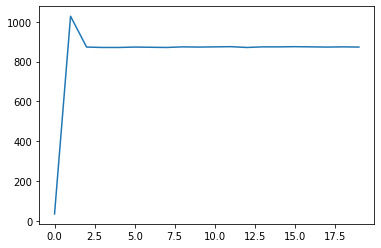

In [33]:
plt.plot(niter1)

In [34]:
k = np.argmin(niter1)
print(lambk[k])

0.0


In [35]:
lamb = lambk[k]
mu = lamb
epsi=0.1
nitermax= 3000
ux,uy,CF,step,n=RecalageGN(im2,im1,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 3.550829550396586 step : 0.08
iteration : 6  cost function : 3.515308509201881 step : 0.64
iteration : 9  cost function : 3.3175005862607145 step : 5.12
iteration : 12  cost function : 3.113172381809368 step : 40.96
iteration : 15  cost function : 2.7869343311277848 step : 327.68
iteration : 18  cost function : 2.3893406680031313 step : 2621.44
iteration : 21  cost function : 2.009249745276657 step : 10485.76
iteration : 24  cost function : 1.9781962400665993 step : 655.36
iteration : 27  cost function : 1.970208701083458 step : 5242.88
iteration : 30  cost function : 1.9645883197663263 step : 5242.88
iteration : 33  cost function : 1.9577136095368692 step : 655.36


on prend lambda = 10,5

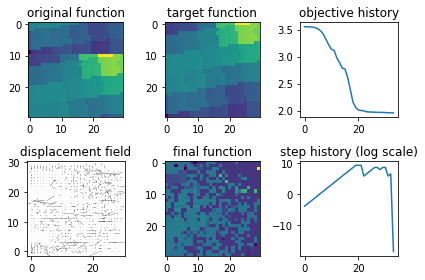

In [36]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(im2)
ax[0,0].set_title('original function')
ax[0,1].imshow(im1)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(im2,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

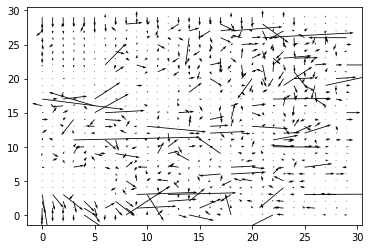

In [37]:
plt.quiver(ux, uy)
plt.show()

5. Jeu des différences
======================
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

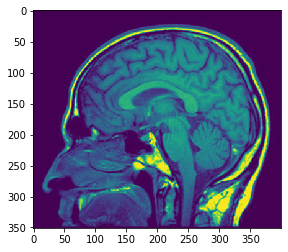

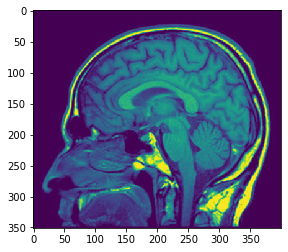

In [13]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

In [14]:
[n,m]=im1.size
sigma=0.1
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

In [ ]:
epsi=0.01
stepini=0.01
nitermax = 5000
lamb = 0.0001
mu = 0.0001
ux,uy,CF,step, niter=RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi)

iteration : 3  cost function : 0.14378266568826878 step : 0.08
iteration : 6  cost function : 0.1435182966307982 step : 0.64
iteration : 9  cost function : 0.1414353121976472 step : 5.12
iteration : 12  cost function : 0.12664688791055412 step : 40.96
iteration : 15  cost function : 0.07367524667918667 step : 327.68
iteration : 18  cost function : 0.054490660858069626 step : 20.48
iteration : 21  cost function : 0.053399614583654234 step : 20.48
iteration : 24  cost function : 0.053030424409352475 step : 10.24
iteration : 27  cost function : 0.05275613354759687 step : 10.24
iteration : 30  cost function : 0.05251414487138783 step : 10.24
iteration : 33  cost function : 0.05236623483392294 step : 10.24
iteration : 36  cost function : 0.05203014453222114 step : 10.24
iteration : 39  cost function : 0.05190443513327623 step : 5.12
iteration : 42  cost function : 0.051618297422295525 step : 5.12
iteration : 45  cost function : 0.05136707555049709 step : 10.24
iteration : 48  cost function 

In [ ]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()